# SNP ANALYSIS OF 3000 RICE GENOMES

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/Red_Rice_Paddy_field_in_Japan_001.jpg" width=750 height=500/>


Image from: https://upload.wikimedia.org/wikipedia/commons/f/f8/Red_Rice_Paddy_field_in_Japan_001.jpg

## Table of Contents
* [SNP ANALYSIS OF 3000 RICE GENOMES](#SNP-ANALYSIS-OF-3000-RICE-GENOMES)
	* [Overview](#Overview.)
        * [Motivation](#Motivation)
        * [Related Work](#Related-Work)
        * [Initial Questions](#Initial-Questions)
    * [Installing Additional Packages](#Installing-Additional-Packages)
    * [Scraping From IRGCIS Database](#Scraping-From-IRGCIS-Database)
		* [Database Access](#Database-Access)
		* [Scraping the Data](#Scraping-the-Data)
		* [Structuring the Queries](#Structuring-the-Queries)
		* [Database Reconstruction](#Database-Reconstruction)
        * [Subselecting for AWS Strains](#Subselecting-for-AWS-Strains)
            * [EDA of Phenotypic Variables](#EDA-of-Phenotypic-Variables)
    * [Feature Based Prediction of Days to Maturity](#Feature-Based-Prediction-of-Days-to-Maturity)
        * [Absolute Baseline](#Absolute-Baseline)
        * [Strain Baseline](#Strain-Baseline)
        * [Strain-Country Baseline Regression](#Strain-Country-Baseline-Regression)
        * [Normalized Strain-Country Baseline Regression](#Normalized-Strain-Country-Baseline-Regression)
    * [Accessing SNP Data](#Accessing-SNP-Data)
        * [Accessing Process](#Accessing-Process)
        * [Database Construction](#Database-Construction)
        * [EDA of SNP Data](#EDA-of-SNP-Data)
    * [Predicting Days to Maturity with SNP Data](#Predicting-Days-to-Maturity-with-SNP-Data)

## Overview

TEXT

### Motivation

TEXT

### Related Work

TEXT

### Initial Questions

TEXT

And with that, let's begin!

In [483]:
# Normal Imports
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# Additional Imports Needed
import requests
from pyquery import PyQuery as pq
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

## Installing Additional Packages

PyVCF was downloaded from https://pypi.python.org/pypi/PyVCF/0.6.0 and added to Python libraries by running the setup.py file. The library can be imported by `import vcf`.

In [ ]:
import vcf

## Scraping From IRGCIS Database

The International Rice Genebank Collection Information System (IRGCIS), is an online, publically accessible database that contains information on over 130,000 rice varieties. The database is set up such that every rice variety has a unique IRGC Accession # associated with it and a number of phenotypic features. The database is designed such that the colums are various features of a rice strain and the rows are for inidivual varities.

### Database Access

Accessing the data from the IRGCIS database involves querying their interface which is shown below. It functions on an AND system such that "`Donor Country = JAPAN`" input to the search with "`Endosperm Type = GLUTINOUS`" shows only Japanese, Glutinous strains. The queries are divided into 8 main queries and a 'Summary' query. Unfortunately each query must be accessed independently to get data on all of the varieties. The query interface and a sample query return are shown below

<img src="images/IRGCIS_Queries.png" width=500 height=300/>
<img src="images/IRGCIS_Sample_Query.png" width=1000 height=1000/>

The code below serves to perform the 8 queries that return features of each rice strain as each query is independent. This will be in the format of the page's HTML. The queries are set to return data on 'all varieties' for each query. The IRGCIS database is quite slow, the requests below took ~2.5 hours to run on my computer.

In [ ]:
# Query the online database for the requisite data
basicinfo=requests.get("http://www.irgcis.irri.org:81/grc/TK.exe$Query?DataSource=IRG&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3E%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3C%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID=&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME-OP=ctn&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME=&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY=&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY-OP=%3D&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY=&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE=&GBUSER_TK_MORPH1_2.MAT-OP=%3E%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.MAT-OP=%3C%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRWD-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.GRWD-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.VG-OP=%3D&GBUSER_TK_MORPH1_2.VG=&GBUSER_TK_MORPH1_2.ENDO-OP=%3D&GBUSER_TK_MORPH1_2.ENDO=&GBUSER_TK_MORPH1_2.SCCO_REV-OP=%3D&GBUSER_TK_MORPH1_2.SCCO_REV=&GBUSER_TK_EVAL.BL_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BL_DESCRIPTION=&GBUSER_TK_EVAL.BB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BB_DESCRIPTION=&GBUSER_TK_EVAL.SHB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.SHB_DESCRIPTION=&Output=%2FGRC%2FAccessionID.htm&Limit=-1")
allinfo=requests.get("http://www.irgcis.irri.org:81/grc/TK.exe$Query?DataSource=IRG&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3E%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3C%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID=&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME-OP=ctn&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME=&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY=&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY-OP=%3D&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY=&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE=&GBUSER_TK_MORPH1_2.MAT-OP=%3E%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.MAT-OP=%3C%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRWD-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.GRWD-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.VG-OP=%3D&GBUSER_TK_MORPH1_2.VG=&GBUSER_TK_MORPH1_2.ENDO-OP=%3D&GBUSER_TK_MORPH1_2.ENDO=&GBUSER_TK_MORPH1_2.SCCO_REV-OP=%3D&GBUSER_TK_MORPH1_2.SCCO_REV=&GBUSER_TK_EVAL.BL_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BL_DESCRIPTION=&GBUSER_TK_EVAL.BB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BB_DESCRIPTION=&GBUSER_TK_EVAL.SHB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.SHB_DESCRIPTION=&Output=%2FGRC%2FDataOnSearchForm.htm&Limit=-1")
locationinfo=requests.get("http://www.irgcis.irri.org:81/grc/TK.exe$Query?DataSource=IRG&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3E%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3C%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID=&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME-OP=ctn&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME=&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY=&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY-OP=%3D&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY=&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE=&GBUSER_TK_MORPH1_2.MAT-OP=%3E%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.MAT-OP=%3C%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRWD-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.GRWD-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.VG-OP=%3D&GBUSER_TK_MORPH1_2.VG=&GBUSER_TK_MORPH1_2.ENDO-OP=%3D&GBUSER_TK_MORPH1_2.ENDO=&GBUSER_TK_MORPH1_2.SCCO_REV-OP=%3D&GBUSER_TK_MORPH1_2.SCCO_REV=&GBUSER_TK_EVAL.BL_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BL_DESCRIPTION=&GBUSER_TK_EVAL.BB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BB_DESCRIPTION=&GBUSER_TK_EVAL.SHB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.SHB_DESCRIPTION=&Output=%2FGRC%2FPassCollectLoc.htm&Limit=-1")
morphoveginfo=requests.get("http://www.irgcis.irri.org:81/grc/TK.exe$Query?DataSource=IRG&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3E%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3C%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID=&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME-OP=ctn&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME=&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY=&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY-OP=%3D&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY=&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE=&GBUSER_TK_MORPH1_2.MAT-OP=%3E%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.MAT-OP=%3C%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRWD-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.GRWD-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.VG-OP=%3D&GBUSER_TK_MORPH1_2.VG=&GBUSER_TK_MORPH1_2.ENDO-OP=%3D&GBUSER_TK_MORPH1_2.ENDO=&GBUSER_TK_MORPH1_2.SCCO_REV-OP=%3D&GBUSER_TK_MORPH1_2.SCCO_REV=&GBUSER_TK_EVAL.BL_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BL_DESCRIPTION=&GBUSER_TK_EVAL.BB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BB_DESCRIPTION=&GBUSER_TK_EVAL.SHB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.SHB_DESCRIPTION=&Output=%2FGRC%2FMorphVegAllSpp.htm&Limit=-1")
morphoreproinfo=requests.get("http://www.irgcis.irri.org:81/grc/TK.exe$Query?DataSource=IRG&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3E%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3C%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID=&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME-OP=ctn&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME=&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY=&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY-OP=%3D&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY=&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE=&GBUSER_TK_MORPH1_2.MAT-OP=%3E%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.MAT-OP=%3C%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRWD-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.GRWD-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.VG-OP=%3D&GBUSER_TK_MORPH1_2.VG=&GBUSER_TK_MORPH1_2.ENDO-OP=%3D&GBUSER_TK_MORPH1_2.ENDO=&GBUSER_TK_MORPH1_2.SCCO_REV-OP=%3D&GBUSER_TK_MORPH1_2.SCCO_REV=&GBUSER_TK_EVAL.BL_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BL_DESCRIPTION=&GBUSER_TK_EVAL.BB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BB_DESCRIPTION=&GBUSER_TK_EVAL.SHB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.SHB_DESCRIPTION=&Output=%2FGRC%2FMorpReproAllSpp.htm&Limit=-1")
morphoharvestinfo=requests.get("http://www.irgcis.irri.org:81/grc/TK.exe$Query?DataSource=IRG&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3E%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3C%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID=&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME-OP=ctn&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME=&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY=&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY-OP=%3D&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY=&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE=&GBUSER_TK_MORPH1_2.MAT-OP=%3E%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.MAT-OP=%3C%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRWD-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.GRWD-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.VG-OP=%3D&GBUSER_TK_MORPH1_2.VG=&GBUSER_TK_MORPH1_2.ENDO-OP=%3D&GBUSER_TK_MORPH1_2.ENDO=&GBUSER_TK_MORPH1_2.SCCO_REV-OP=%3D&GBUSER_TK_MORPH1_2.SCCO_REV=&GBUSER_TK_EVAL.BL_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BL_DESCRIPTION=&GBUSER_TK_EVAL.BB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BB_DESCRIPTION=&GBUSER_TK_EVAL.SHB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.SHB_DESCRIPTION=&Output=%2FGRC%2FMorphHarvPostAllSpp.htm&Limit=-1")
diseasereactioninfo=requests.get("http://www.irgcis.irri.org:81/grc/TK.exe$Query?DataSource=IRG&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3E%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3C%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID=&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME-OP=ctn&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME=&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY=&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY-OP=%3D&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY=&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE=&GBUSER_TK_MORPH1_2.MAT-OP=%3E%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.MAT-OP=%3C%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRWD-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.GRWD-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.VG-OP=%3D&GBUSER_TK_MORPH1_2.VG=&GBUSER_TK_MORPH1_2.ENDO-OP=%3D&GBUSER_TK_MORPH1_2.ENDO=&GBUSER_TK_MORPH1_2.SCCO_REV-OP=%3D&GBUSER_TK_MORPH1_2.SCCO_REV=&GBUSER_TK_EVAL.BL_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BL_DESCRIPTION=&GBUSER_TK_EVAL.BB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BB_DESCRIPTION=&GBUSER_TK_EVAL.SHB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.SHB_DESCRIPTION=&Output=%2FGRC%2FDisease_resist.htm&Limit=-1")
envreactioninfo=requests.get("http://www.irgcis.irri.org:81/grc/TK.exe$Query?DataSource=IRG&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.STATUS_ACC=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3E%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO-OP=%3C%3D&GBUSER_TK_PASS1_ORICOUNTRY.ACCNO=&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.SPECIES_REID=&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME-OP=ctn&GBUSER_TK_PASS1_ORICOUNTRY.ALL_ACCNO_NAME=&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.ORI_COUNTRY=&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY-OP=%3D&GBUSER_TK_PASS1_SSCOUNTRY.SS_COUNTRY=&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE-OP=%3D&GBUSER_TK_PASS1_ORICOUNTRY.CULT_TYPE=&GBUSER_TK_MORPH1_2.MAT-OP=%3E%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.MAT-OP=%3C%3D&GBUSER_TK_MORPH1_2.MAT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRLT-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRLT=&GBUSER_TK_MORPH1_2.GRWD-OP=%3E%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.GRWD-OP=%3C%3D&GBUSER_TK_MORPH1_2.GRWD=&GBUSER_TK_MORPH1_2.VG-OP=%3D&GBUSER_TK_MORPH1_2.VG=&GBUSER_TK_MORPH1_2.ENDO-OP=%3D&GBUSER_TK_MORPH1_2.ENDO=&GBUSER_TK_MORPH1_2.SCCO_REV-OP=%3D&GBUSER_TK_MORPH1_2.SCCO_REV=&GBUSER_TK_EVAL.BL_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BL_DESCRIPTION=&GBUSER_TK_EVAL.BB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.BB_DESCRIPTION=&GBUSER_TK_EVAL.SHB_DESCRIPTION-OP=ctn&GBUSER_TK_EVAL.SHB_DESCRIPTION=&Output=%2FGRC%2FPhysiochem.htm&Limit=-1")

    CPU times: user 40.4 s, sys: 19.3 s, total: 59.7 s
    Wall time: 2h 38min 27s

### Structuring the Queries

As each query contains different information, there is no good way to combine the data from each query. As such, the function below, `dict_builder`, works by parsing through each row of a given query type and building a list of dictionaries, one for each strain within the query. The keys are the features within a query and the values are the contents of the cell. 

*Note:* Every query contains a `strain_id` field, which is a unique identifier that will be used to merge the queries later on

In [ ]:
"""
Function
--------
dict_builder

Inputs
------
query: the type request from the IRGCIS database
    e.g. querying the 'location information'  
rows: the HTML returned from the request
   
Returns
-------

a list of dictionaries, each of which corresponds to a rice strain with
    information depending upon the query type

E.g. for a query on location info:

{'strain_id': 109900, 
 'species_name': 'O. japonica', 
 'variety_name': 'Sativa',
 'province': 'Japan',
 'district': 'South',
 'town': 'Kyoto', 
 'village': 'null', 
 'latitude': '23', 
 'longitude': '55', 
 'altitude': '200'}

Notes
-----
Each query type returns a unique set of information contained 
"""

def dict_builder(query,rows):
    
    # Define fields to define columns from IRGC database for each query
    if query == 'basicinfo':
        fields=['strain_id', 'species_name', 'variety_name', 'previous_name', 
                'pedigree', 'collection_number', 'acc_id_seq_num', 'acc_id_seed_donor_number',
                'source_country', 'donor_country', 'acc_date', 'status', 'cultural_type',
                'special_traits', 'fao_in_trust', 'multilateral_system']
    elif query == 'allinfo':
        fields=['strain_id', 'species_name', 'variety_name', 'previous_name', 
                'pedigree', 'collection_number', 'acc_id_seed_donor_number',
                'source_country', 'cultural_type','days_to_mat', 'grain_len',
                'grain_wid', 'varietal_group', 'endosperm_type', 'endosperm_color',
                'seed_coat_color', 'rice_blast', 'bacterial_blight', 'sheath_blight']
    elif query == 'locationinfo':
        fields=['strain_id', 'species_name', 'variety_name', 'province',
                'district', 'town', 'village', 'latitude', 'longitude', 'altitude']
    elif query == 'morphoveginfo':
        fields=['strain_id', 'subpopulation', 'species_name', 'variety_name', 
                'source_country', 'blade_pub', 'blade_color', 'basal_color', 'ligule_shape',
                'leaf_texture', 'leaf_angle', 'seedling_height', 'ligule_color', 
                'collar_color', 'auricle_color']
    elif query == 'morphoreproinfo':
        fields=['strain_id', 'subpopulation', 'species_name', 'variety_name', 
                'source_country', 'culm_angle', 'node_color', 'internode_color', 
                'internode_color', 'culm_strength', 'flat_leaf_angle', 'flag_leaf_angle',
                'panicle', 'secondary_branching', 'panicle_exerion', 'panicle_axis',
                'awn_presence', 'awn_color', 'apiculus_color', 'stigma_color', 'lemma_color',
                'leaf_length', 'leaf_width', 'culm_length', 'culm_num', 'culm_diam', 
                'days_to_head', 'variety_group_from_morph', 'days_to_flower', 'lingule_pub',
                'lemma_color_at_anthesis', 'internode_color','culm_strength_cult']
    elif query == 'morphoharvestinfo':
        fields=['strain_id', 'species_name', 'variety_name', 'source_country', 
                'days_to_maturity', 'panicle_shattering', 'leaf_senescence', 'spikelet_fertility',
                'panicle_thesability', 'apiculus_color_post_harv', 'lemma_and_palea_color',
                'lemma_and_palea_pub', 'seat_coat_color']
    elif query == 'diseasereactioninfo':
        fields=['strain_id', 'species_name', 'variety_name', 'source_country', 
                'blast', 'bacterial_blight', 'sheath_blight', 'tungro_virus']
    elif query == 'envreactioninfo':
        fields=['strain_id', 'species_name', 'variety_name', 'source_country', 
                'alkali_tolerance', 'cold_tolerance', 'drought_1', 'drought_2',
                'drought_3', 'drought_4', 'drought_5', 'drought_6', 'drought_7',
                'drought_8', 'drought_9', 'elogation', 'flood_tolerance', 
                'salt_tolerance', 'zinc_def_1', 'zinc_def_1']
    else:
        fields =[]

    # create list to hold the dict for every strain    
    ricestrains=[]
    for r in rows:
        
        # iterate through every cell in a row and get the text inside
        d_td=pq(r)('td')
        a = [pq(d_td[i]).text() for i in range(0,len(pq(d_td)))]

        # create a dict for that strain and append to the growing list
        ricedict = dict(zip(fields,a))
        ricestrains.append(ricedict)
    
    return ricestrains

The cell below takes all of the queries, and using PyQuery, turns the requests into the HTML of the page. The IRGCIS website was terribly formatted - it had an `</HTML>` tag before the table containing the information even began. There are header rows (e.g. `Guide to Collection Statistics`) which are not relevant to the data that are in the HTML without a separating container or div. As such, the first 4 rows are thrown out to pass only the `tr` rows from the actual table to the dict_builder function. The end result is a list of tuples stored as (query, [dicts of features for every strain])

In [ ]:
# define a list of all of the queries
scrapedlist = [('basicinfo',basicinfo), ('allinfo',allinfo), 
              ('locationinfo',locationinfo), ('morphoveginfo',morphoveginfo),
              ('morphoreproinfo',morphoreproinfo), ('morphoharvestinfo',morphoharvestinfo), 
              ('diseasereactioninfo',diseasereactioninfo), ('envreactioninfo',envreactioninfo)]

dict_list=[]

# iterate through queries creating a list of tuples organized as (query,[dicts for each strain]) 
for k,v in scrapedlist:
    
    # cleans the HTML before passing to dict_builder
    d_= pq(v.text)
    d_rows = pq(d_('tr')[4:])
    d_rows = pq(d_rows[:(len(d_rows)-1)])

    dict_list.append((k, dict_builder(k,pq(d_rows))))

Seeing how many strains we recovered for each query, creating a dataframe for each and saving each df as a pickle along the way (to cache), we see we recovered varing numbers of strains (rows) for each query:

In [ ]:
for k,v in dict_list:
    # Print how many rows each df will have
    print k + " rows: " + str(len(v))
    
    # Create a dataframe of each and save as a pickle
    a = pd.DataFrame(v)
    picklename=('tempdata/'+k)
    a.to_pickle(picklename)

    basicinfo rows: 131112
    allinfo rows: 134842
    locationinfo rows: 127128
    morphoveginfo rows: 130800
    morphoreproinfo rows: 130800
    morphoharvestinfo rows: 130800
    diseasereactioninfo rows: 127128
    envreactioninfo rows: 127128

### Database Reconstruction

We read back in our pickles for each to load them back into memory, setting their index to the unique strain ids (this was done to make start-up faster such that the 2.5 hour querying doesn't need to be repeated). We save the pickles to an array and get the maximum number strains in `full_ids`, which is obtained from `allinfo`, the df with the most rows in preparation for a merging of the dfs.

In [ ]:
#load all of the files from pickles in tempdata and set index to strain_id
basicinfo=pd.read_pickle('tempdata/basicinfo').set_index('strain_id')
allinfo=pd.read_pickle('tempdata/allinfo').set_index('strain_id')
diseasereactioninfo=pd.read_pickle('tempdata/diseasereactioninfo').set_index('strain_id')
envreactioninfo=pd.read_pickle('tempdata/envreactioninfo').set_index('strain_id')
locationinfo=pd.read_pickle('tempdata/locationinfo').set_index('strain_id')
morphoharvestinfo=pd.read_pickle('tempdata/morphoharvestinfo').set_index('strain_id')
morphoreproinfo=pd.read_pickle('tempdata/morphoreproinfo').set_index('strain_id')
morphoveginfo=pd.read_pickle('tempdata/morphoveginfo').set_index('strain_id')

In [ ]:
#save all of the dataframes into an array
dataframes=[basicinfo,allinfo,diseasereactioninfo,envreactioninfo,locationinfo,morphoharvestinfo,morphoreproinfo,morphoveginfo]

In [ ]:
#extract all of the ids from allinfo (allinfo has the greatest number of strain ids out of all of the dataframes)
full_ids=allinfo.index.tolist();

The function `create_new_dataframe` takes in a list of the ids to be used in the merging of the array of data frames. It generates a fresh dataframe consisting of the unique columns, corresponding to features, from the individual dfs. It then iterates over the list of ids and for each generates a row, which is then filled with the data from the inividual query dataframes. The end result is a merged dataframe consisting of the features from each query, matched by the unique `strain_id`. 

In [ ]:
"""
Function
--------
create_new_dataframe

Inputs
------
ids: an array of ids that will be included in the new dataframe
dfs: an array of data frames that will be combined to form the new dataframe
   
Returns
-------

a populated data frame that includes a row for each of the ids inputed 
    and a column for each of the columns includedd in each of the inputted data frames

Notes
-----
This code takes over 3 hours to run with all of the previous data frames included 
"""
def create_new_dataframe(ids, dfs):
    #create array to store column names
    columns=[]
    #iterate through every dataframe
    for d in dfs:
        #add column names from dataframe to columns array
        columns.extend(list(d.columns.values))
    #determine every unique column in array
    columns=np.unique(columns)
    #create final dataframe with unique columns
    fdf=pd.DataFrame(columns=columns)
    #go through each id
    for i in ids:
        #create dict to store values for the specific row
        row={}
        #go through each dataframe
        for d in dfs:
            #if id value is in the dataframe add data to row as dict
            if str(i) in d.index.values:
                row.update(d.loc[str(i)].to_dict())
        #add row to final dataframe
        fdf=fdf.append(pd.DataFrame(row, index=[i]))
    #after every id has been iterated through, return final dataframe
    return fdf

With the function written, its time to merge the queries into one large df! This code takes ~3 hours to run

In [ ]:
all_info=create_new_dataframe(full_ids, dataframes)

We can now save the `all_info` dataframe and have an optional load, for faster restarting. This data frame could also be saved and used for feature analysis and prediction in the future in a manner comperable to HW3. 

In [491]:
# Saving the dataframe
all_info.to_csv('data/all_info_combined.csv', encoding='utf-8')
# Optional reloading
all_info = pd.read_csv('data/all_info_combined.csv', index_col=0)

In [492]:
print all_info.shape
all_info.head()

(134842, 94)


,acc_date,acc_id_seed_donor_number,acc_id_seq_num,alkali_tolerance,altitude,apiculus_color,apiculus_color_post_harv,auricle_color,awn_color,awn_presence,bacterial_blight,basal_color,blade_color,blade_pub,blast,cold_tolerance,collar_color,collection_number,culm_angle,culm_diam,culm_length,culm_num,culm_strength,cultural_type,days_to_flower,days_to_head,days_to_mat,days_to_maturity,district,donor_country,drought_1,drought_2,drought_3,drought_4,drought_5,drought_6,drought_7,drought_8,drought_9,elogation,endosperm_color,endosperm_type,fao_in_trust,flag_leaf_angle,flat_leaf_angle,flood_tolerance,grain_len,grain_wid,internode_color,latitude,leaf_angle,leaf_length,leaf_senescence,leaf_texture,leaf_width,lemma_and_palea_color,lemma_and_palea_pub,lemma_color,lemma_color_at_anthesis,ligule_color,ligule_shape,lingule_pub,longitude,multilateral_system,node_color,panicle,panicle_axis,panicle_exerion,panicle_shattering,panicle_thesability,pedigree,previous_name,province,rice_blast,salt_tolerance,seat_coat_color,secondary_branching,seed_coat_color,seedling_height,sheath_blight,source_country,special_traits,species_name,spikelet_fertility,status,stigma_color,subpopulation,town,tungro_virus,varietal_group,variety_group_from_morph,variety_name,village,zinc_def_1
83768,9/22/1994,8800314,2,X,1500,020,080,Purple,080,080,NaN,Purple,Green,Pubescent,NaN,X,Purple,NaN,Open (5),1,2,83,5,NaN,X,NaN,113,113,NaN,JAPAN,X,X,X,X,X,X,X,X,X,X,White,Non-glutinous(non-waxy),Yes,1,9,X,7,2,3,0,Drooping(9),131-150 cm,5,NaN,3,053,4,2,Moderately strong(most plants leaning),Whitish,2-Cleft,Light gold,0,Yes,Purple,1,080,1,3,5,TN/NEPAL/IBPGR/85/837,NaN,NaN,NaN,X,010,2,NaN,Intermediate (30-59 cm),NaN,NEPAL,NaN,O. sativa,3,NaN,3,A,Zatobania Divajor,0,Indica,NaN,NaN,NaN,X
83794,12/26/1988,G.S. 18252,1,X,140,X,X,NaN,080,X,NaN,Green,Green,Pubescent,NaN,X,NaN,086/88/TNE34; SRN-88-502,Spreading (7),X,X,0,X,NaN,062,141,0,0,Tha Tum,THAILAND,X,X,X,X,X,X,X,X,X,X,Red,Non-glutinous(non-waxy),Yes,1,8,X,8,2,X,15,NaN,>150 cm,9,Coriaceous,X,X,X,X,NaN,NaN,2-Cleft,NaN,103,Yes,Green,1,080,9,9,X,NaN,NaN,Surin,NaN,X,070,X,NaN,NaN,NaN,THAILAND,NaN,O. rufipogon,3,NaN,X,C,Thung Kula,0,NaN,Glabrous,NaN,NaN,X
83764,9/22/1994,00080232,2,X,1000,020,020,Light green,010,020,NaN,Green,Green,Pubescent,NaN,X,Light green,NaN,Spreading (7),1,2,108,7,NaN,X,NaN,138,138,NaN,JAPAN,X,X,X,X,X,X,X,X,X,X,White,Non-glutinous(non-waxy),Yes,1,5,X,6,2,7,28,Drooping(9),NaN,3,NaN,X,020,5,X,Weak(most plants nearly flat),Whitish,2-Cleft,Green,83,Yes,Green,1,000,0,1,9,TN/NEPAL/IBPGR/85/453,NaN,NaN,NaN,X,010,2,NaN,NaN,NaN,NEPAL,NaN,O. sativa,3,NaN,X,A,Birethanti,0,Indica,NaN,NaN,NaN,X
83764,9/22/1994,00080232,2,X,1000,020,020,Light green,010,020,NaN,Green,Green,Pubescent,NaN,X,Light green,NaN,Spreading (7),1,2,108,7,NaN,X,NaN,138,138,NaN,JAPAN,X,X,X,X,X,X,X,X,X,X,White,Non-glutinous(non-waxy),Yes,1,5,X,6,2,7,28,Drooping(9),NaN,3,NaN,X,020,5,X,Weak(most plants nearly flat),Whitish,2-Cleft,Green,83,Yes,Green,1,000,0,1,9,TN/NEPAL/IBPGR/85/453,NaN,NaN,NaN,X,010,2,NaN,NaN,NaN,NEPAL,NaN,O. sativa,3,NaN,X,A,Birethanti,0,Indica,NaN,NaN,NaN,X
83765,9/22/1994,00080249,2,X,1400,020,080,Light green,010,020,NaN,Green,Green,Pubescent,NaN,X,Light green,NaN,Open (5),1,2,90,5,NaN,X,NaN,120,120,NaN,JAPAN,X,X,X,X,X,X,X,X,X,X,Red,Non-glutinous(non-waxy),Yes,1,7,X,8,2,5,0,Drooping(9),131-150 cm,5,NaN,2,091,4,2,Intermediate(most plants moderately lodged),Whitish,2-Cleft,Green,0,Yes,Green,1,020,9,3,1,TN/NEPAL/IBPGR/85/507,NaN,NaN,NaN,X,070,2,NaN,Intermediate (30-59 cm),NaN,NEPAL,NaN,O. sativa,3,NaN,3,A,Dyikur Porhari,0,Indica,NaN,NaN,NaN,X


### Subselecting for AWS Strains

Now its time to match the 134,842 IRGCIS strains in our `all_info` dataframe to the 3024 AWS strains! We obtained an index file that acts as our Rosetta Stone. The file `index.csv` is a file modified (copying data from multiple sheets onto one) from http://www.gigasciencejournal.com/content/supplementary/2047-217x-3-7-s1.xlsx and converted to a CSV. It allows us to match the IRGCIS number (`strain_id` in the `all_info`) to the `DNA_Accno_source` field in the `index.csv`. With this match, we can use the `index.csv` to subselect our dataframe and will now have a matched `DNA_UNIQUE_ID` an unique number prefaced by IRIS, which is what the AWS SNP data uses to uniquely identify each strain.

PROCESS:

`all_info`(`strain_id`) = `index.csv`(`DNA_Accno_source`) <==> `index.csv`(`DNA_UNIQUE_ID`) = `AWS`(`ids`)

In [ ]:
index_df=pd.read_csv("data/index.csv")

In [ ]:
#create array to store IRGC Number in
array=[]
#go through every row in dataframe
for r in index_df.index:
    #determine if DNA_Accno_source is a string
    if isinstance(index_df.ix[r]["DNA_Accno_source"], str):
        #if it is, add the numeric part of string to array
        array.append(int(index_df.ix[r]["DNA_Accno_source"][5:]))
    #if DNA_Accno_sourse does not exist, add NaN to array
    else:
        array.append(np.nan)
#add array as a new column in index_df
index_df.insert(5, "IRGC_Number", array);

In [ ]:
#create merged dataframe by merging index_df rows and all_info rows that share the same strain id number
merged_df_updated=pd.merge(left=index_df,right=all_info, left_on='IRGC_Number', right_index=True)

We can now save the all_info dataframe and have an optional load, for faster restarting

In [493]:
# Saving the Dataframe
merged_df_updated.to_csv("data/merged_dataframe_updated.csv")
# Optional reloading
merged_df_updated = pd.read_csv('data/merged_dataframe_updated.csv', index_col=0)
print merged_df_updated.shape
merged_df_updated.head()

(2347, 110)


,Entry_No,Source,DNA_UNIQUE_ID,DNA_Designation,DNA_Accno_source,IRGC_Number,DNA_VARNAME_source,DNA_Othername_source,ORI_COUNTRY,Unnamed: 8,Genetic_Stock_Accno,Genetic_stock_Designation(varname),total seq count,passed qc seq count,depth,Variety Group (Tree)1,acc_date,acc_id_seed_donor_number,acc_id_seq_num,alkali_tolerance,altitude,apiculus_color,apiculus_color_post_harv,auricle_color,awn_color,awn_presence,bacterial_blight,basal_color,blade_color,blade_pub,blast,cold_tolerance,collar_color,collection_number,culm_angle,culm_diam,culm_length,culm_num,culm_strength,cultural_type,days_to_flower,days_to_head,days_to_mat,days_to_maturity,district,donor_country,drought_1,drought_2,drought_3,drought_4,...,flat_leaf_angle,flood_tolerance,grain_len,grain_wid,internode_color,latitude,leaf_angle,leaf_length,leaf_senescence,leaf_texture,leaf_width,lemma_and_palea_color,lemma_and_palea_pub,lemma_color,lemma_color_at_anthesis,ligule_color,ligule_shape,lingule_pub,longitude,multilateral_system,node_color,panicle,panicle_axis,panicle_exerion,panicle_shattering,panicle_thesability,pedigree,previous_name,province,rice_blast,salt_tolerance,seat_coat_color,secondary_branching,seed_coat_color,seedling_height,sheath_blight,source_country,special_traits,species_name,spikelet_fertility,status,stigma_color,subpopulation,town,tungro_virus,varietal_group,variety_group_from_morph,variety_name,village,zinc_def_1
0,65,IRRI,IRIS 313-9783,BERENJ 1277 S::IRGC 3461-1-1,IRGC 3461,3461,BERENJ 1277 S,NaN,AFGHANISTAN,Afghanistan,IRGC 121902,BERENJ 1277 S::IRGC 3461-1,NaN,NaN,NaN,Japonica,NaN,PI 223894,1,X,NaN,X,X,Light green,010,070,NaN,Green,Green,Pubescent,Susceptible,X,Green,NaN,Erect (1),1,1,80,1,NaN,X,NaN,110,110,NaN,UNITED STATES,5,3,X,5,...,9,X,9,2,7,33,NaN,71-90 cm,9,NaN,2,020,X,1,Weak(most plants nearly flat),Whitish,NaN,Green,67,Yes,NaN,1,020,1,X,5,NaN,NaN,NaN,NaN,X,010,X,Susceptible,Short (,Moderately resistant,AFGHANISTAN,NaN,O. sativa,7,Landrace/Traditional cultivar,3,A,NaN,0,Indica,NaN,BERENJ 1277 S,NaN,X
1,1632,IRRI,IRIS 313-10509,AMBARIKORI::IRGC 5132-1,IRGC 5132,5132,AMBARIKORI,NaN,AFRICA,Africa,IRGC 127120,AMBARIKORI::IRGC 5132-1,NaN,NaN,NaN,Indica,4/7/1962,NaN,NaN,X,NaN,X,X,Light green,010,010,Susceptible,Green,Green,Pubescent,Resistant,X,Green,NaN,Erect (1),1,2,134,1,NaN,X,NaN,164,164,NaN,PHILIPPINES,5,5,X,6,...,9,X,8,2,1,-33,NaN,131-150 cm,9,NaN,3,054,X,2,Strong(no lodging),Whitish,NaN,Green,26,Yes,NaN,1,000,0,X,5,NaN,NaN,NaN,Susceptible,X,010,X,Resistant,Intermediate (30-59 cm),NaN,AFRICA,NaN,O. sativa,3,NaN,4,A,NaN,93,Indica,NaN,AMBARIKORI,NaN,X
3,363,IRRI,IRIS 313-9778,GENIT::IRGC 3272-1-1,IRGC 3272,3272,GENIT,NaN,ARGENTINA,Argentina,IRGC 125751,GENIT::IRGC 3272-1,66457214,60982350,12.7,Indica,NaN,PI 238490,1,X,NaN,X,X,Light green,010,010,NaN,Green,Green,Pubescent,Susceptible,X,Green,NaN,Erect (1),1,2,89,1,NaN,X,NaN,119,119,NaN,UNITED STATES,1,3,X,5,...,9,X,8,3,1,-38,NaN,111-130 cm,9,NaN,3,020,X,2,Strong(no lodging),Whitish,NaN,Green,-63,Yes,NaN,1,000,0,X,1,NaN,NaN,NaN,NaN,X,070,X,Susceptible,Short (,NaN,ARGENTINA,NaN,O. sativa,5,Breeding and inbred line,3,A,NaN,0,Indica,NaN,GENIT,NaN,X
8,659,IRRI,IRIS 313-9980,FORTUNA INIA::IRGC 55865-1-1,IRGC 55865,55865,FORTUNA INIA,NaN,ARGENTINA,Argentina,IRGC 125741,FORTUNA INIA::IRGC 55865-1,58030858,58030858,12.0,Japonica,1/2/1980,NaN,NaN,X,NaN,020,X,Light green,010,020,NaN,Green,Dark green,Pubescent,NaN,X,Light green,NaN,Intermediate (3),1,1,80,5,NaN,X,NaN,110,110,NaN,COLOMBIA,X,X,X,X,...,5,X,10,3,3,-38,Intermediate(3),71-90 cm,1,NaN,2,020,5,2,Moderately strong(most plants leaning),Whitish,2-Cleft,Light gold,-63,Yes,NaN,1,000,0,1,5,NaN,NaN,NaN,NaN,X,010,2,NaN,Short (,NaN,ARGENTINA,NaN,O. sativa,3,NaN,3,A,NaN,0,Indica,NaN,FORTUNA INIA,NaN,X
12,365,IRRI,IRIS 313-9795,HD 10::IRGC 6638-1-1,IRGC 6638,6638,HD10,NaN,AUSTRALIA,Australia,IRGC 125759,HD 10::IRGC 6638-1,56277286,56277286,11.7,Indica,7/30/1962,NaN,NaN,X,NaN,X,X,Light green,010,010,Susceptible,Green,Green,Pubescent,Moderately resistant,X,Green,Na

#### EDA of Phenotypic Variables

Let's explore some of the variables in the `merged_df_updated` df! First we see how many total columns exist, then drop anything without a name as its useless to us, then remove some of the unique identifiers for our EDA to get usable features for predictions

In [484]:
# How many total columns are in the merged_df
print "Number of uncleaned variables: " + str(len(merged_df_updated.columns))

# Generate a new df to preform EDA on, dropping singular values other than strain_id
eda_df = merged_df_updated[list(all_info.columns)]

for col in eda_df.columns:
    if 'Unnamed' in col:
        del eda_df[col]
        
eda_df = eda_df.drop(['acc_date','acc_id_seed_donor_number','acc_id_seq_num',
                      'collection_number','variety_name', 'variety_group_from_morph'],1)

print "Number of usable variables: " + str(len(eda_df.dtypes))

Number of uncleaned variables: 110
Number of usable variables: 88


We check out how "full" each feature is (checking for not NaN) and how "unique" each feature is. For instance, is it categorical (a few options) or is it a large number of discreet options?

In [496]:
# Fullness = % not NAN
fullness=[]
# Uniqueness = % unique variables w/in variable type
uniqueness=[]

# Iterate through columns to see what is full / unique
for column in eda_df.columns:
    values = []
    for value in eda_df[column]:
        # Checks for NAN values
        if value == value:
            values.append(value)
    # Append % full and # of unique values
    fullness.append((column,((float(len(values)))/(float(len(eda_df[column]))))))
    uniqueness.append((column,len(np.unique(values))))
    
# Sort descending    
fullness.sort(key=lambda tup: tup[1],reverse=True)
uniqueness.sort(key=lambda tup: tup[1],reverse=True)

Plotting Fullness:

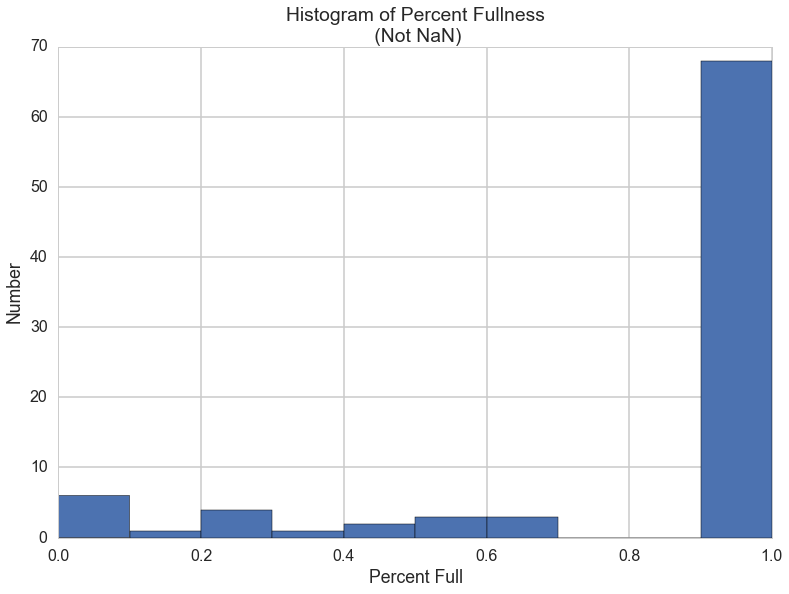

In [495]:
# Unzip fullness, make a histogram
x,y = zip(*fullness)
plt.hist(y);
plt.title('Histogram of Percent Fullness \n (Not NaN)')
plt.xlabel('Percent Full')
plt.ylabel('Number');

In [499]:
fullness[0], fullness[-1]

(('alkali_tolerance', 1.0), ('leaf_texture', 0.0))

This is encouraging! We have ~70 features that we can work with that are 90-100% not NaN, aka not full of junk. `alkali_tolerance` for instance, has no NaN values. It is also interesting to note that there are some variables which are almost entirely NaN variables, e.g. `leaf_texture` is 100% NaN.

Note: We don't drop rows with NaN right now, as disperal of NaN's across different features could severly limit the number of strains we could work with

Moving on to uniqueness:

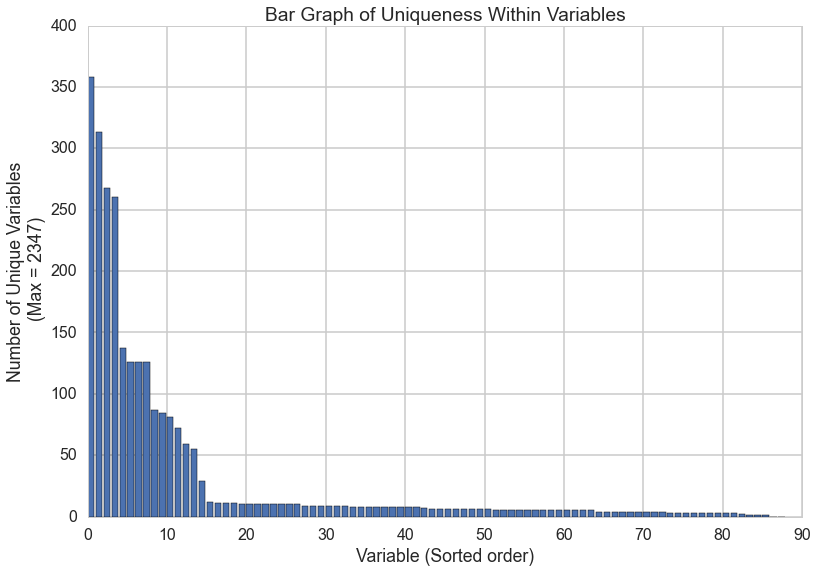

In [509]:
# Unzip uniqueness and plot a bar graph
x,y = zip(*uniqueness)
plt.bar(xrange(0,len(x)),y)
plt.title('Bar Graph of Uniqueness Within Variables')
plt.xlabel('Variable (Sorted order)')
plt.ylabel('Number of Unique Variables \n (Max = 2347)');

In [505]:
uniqueness[0],uniqueness[10], uniqueness[-10]

(('district', 358), ('tungro_virus', 81), ('seed_coat_color', 3))

We removed the unique identifiers earlier, so it is not surprising that nothing hit the the full 2374 possible values. It appears that data falls into several chunks - highly variant data, data that persits in the ~100 values range, and then data that occurs closer to 10 or so values. This makes sense- we have some very variant features, such as `district` which are likely to be fairly unique among rice varieties, variables such as `tungro_virus` which was a rating of % infected (thus 100 possible values, but this takes on 81), and categorical variables such as `seed_coat_color`, which have significantly fewer options and are thereby less unique.

Inspecting the top 20 most unique variables:

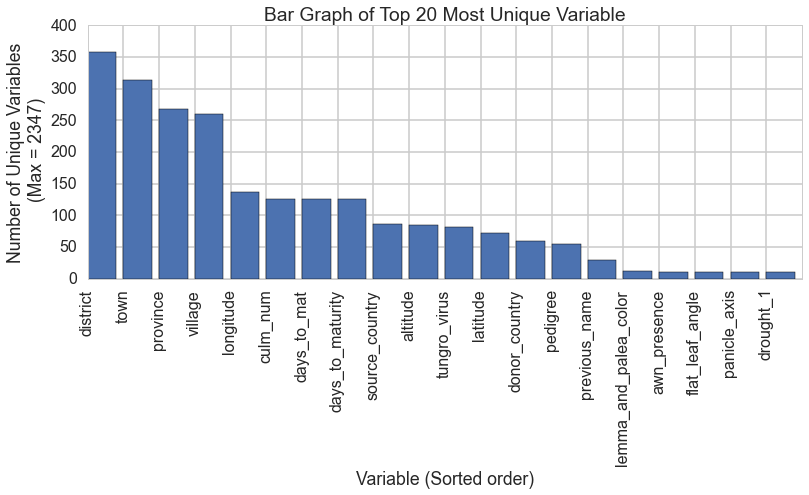

In [510]:
# Plot the top 20 most uniue
plt.bar(xrange(0,20),y[:20])
plt.xticks(xrange(0,20),(x[:20]),rotation='vertical',);
plt.subplots_adjust(bottom=0.5)
plt.title('Bar Graph of Top 20 Most Unique Variable')
plt.xlabel('Variable (Sorted order)')
plt.ylabel('Number of Unique Variables \n (Max = 2347)');

Interestingly, albeit not suprisingly, the most unique features are those with geographic location. Larger geographic locals tend to get less unique (e.g. `town` is more unique than `province`), but this is not a solid rule. `days_to_mat` is the most interesting variable that is fairly diverse. As such, and based on its relative importance to agriculture and feeding humans, it seems to us to be the best variable to carry out our analysis on. `tungro_virus` would also be interesting to come back to for further analysis.

Checking out the least unique variables:

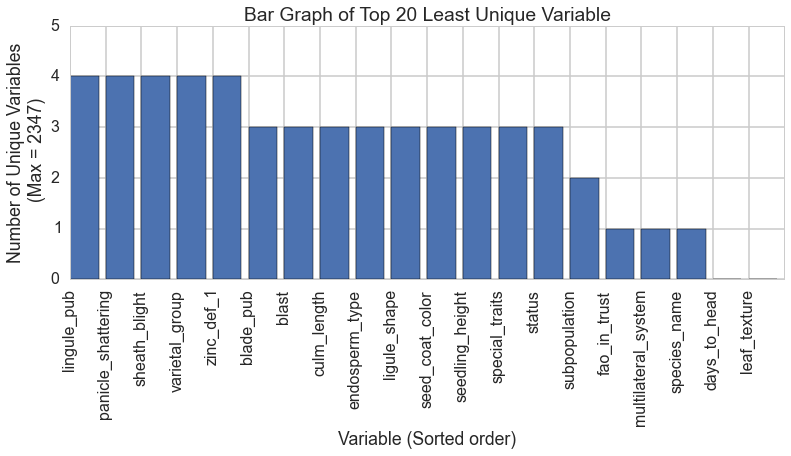

In [516]:
# Plot the bottome 20 most unique
plt.bar(xrange(0,20),y[-20:])
plt.xticks(xrange(0,20),(x[-20:]),rotation='vertical',);
plt.subplots_adjust(bottom=0.5)
plt.axis([0,20,0,5]);
plt.title('Bar Graph of Top 20 Least Unique Variable')
plt.xlabel('Variable (Sorted order)')
plt.ylabel('Number of Unique Variables \n (Max = 2347)');

As was expected, these variables are a entirely categorical. We've demed these less interesting to perform analysis on, however `blast` is a measure of suceptibility to a bacterial pest and might prove interesting to perform future analysis on.

Moving into greater analysis of the `days_to_mat` variable, we see that it is fairly normally distributed. This is to be expected as it is a continuous phenotypic trait, cominatoral genetic factors coupled with environmental interactions produce normally looking distributions of phenotypes like height. (See the work of RA Fischer for more detail)

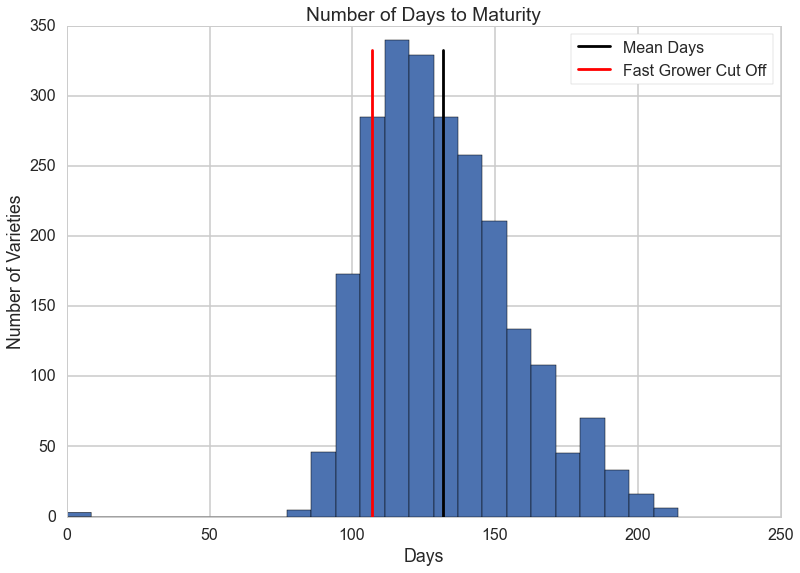

In [489]:
# Plot 
plt.hist(eda_df['days_to_mat'], bins=25);
plt.title('Number of Days to Maturity')
plt.xlabel('Days')
plt.ylabel('Number of Varieties');
plt.axvline(np.mean(eda_df['days_to_mat']), label='Mean Days', color='black',ymax=.95)
plt.axvline(np.mean(eda_df['days_to_mat'])-np.std(eda_df['days_to_mat']), 
            label='Fast Grower Cut Off',color='red',ymax=.95)
plt.legend(frameon=True);


## Feature Based Prediction of Days to Maturity

Now that we've honed in on wanting to predict `days_to_mat`, lets see how well we can do just using some baseline modeling and understandably related features of the rice varieties. 

### Absolute Baseline

We define a new df which we will use for this feature analysis, keeping only `DNA_UNIQUE_ID`, `Variety Group (Tree)1`, `days_to_mat` and `source_country` which will be used in our modeling

In [518]:
# read in the csv saved earlier for faster restarting
metricsdf = pd.read_csv('data/merged_dataframe_updated.csv')

# declare a new df, just with variables of interest
mat_df=metricsdf[['DNA_UNIQUE_ID','Variety Group (Tree)1',
                  'days_to_mat','source_country']]

print mat_df.shape
mat_df.head()

(2347, 4)


,DNA_UNIQUE_ID,Variety Group (Tree)1,days_to_mat,source_country
0,IRIS 313-9783,Japonica,110,AFGHANISTAN
1,IRIS 313-10509,Indica,164,AFRICA
2,IRIS 313-9778,Indica,119,ARGENTINA
3,IRIS 313-9980,Japonica,110,ARGENTINA
4,IRIS 313-9795,Indica,135,AUSTRALIA


Looking at the distribution:

In [519]:
# drop strains with 0 days to maturity (this is impossible)
mat_df = mat_df[mat_df['days_to_mat'] != 0]

# get stats on the days_to_mat variable
days_list = np.array(mat_df['days_to_mat'])

print "count: " + str(len(days_list))
print "min: " + str(days_list.min())
print "max: " + str(days_list.max())
print "mean: " + str(days_list.mean())
print "std: " + str(days_list.std())

count: 2344
min: 80
max: 214
mean: 131.939419795
std: 24.4010276948


Time to begin modeling - We create a mask which will be used to keep the training and test data separate

In [520]:
from sklearn.cross_validation import train_test_split

# Set mask to 70% train, 30% test
itrain, itest = train_test_split(xrange(mat_df.shape[0]), train_size=0.7)
mask=np.ones(mat_df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask.shape, mask.sum()

((2344,), 1640)

We change the `days_to_mat` variable to a float, define a `stdardized_mat` variable based on its z-score, and introduce a new binary variable called `fast` to tell if a strain is fast growing or not. We define "fast" to be any strain which grows faster than 1 standard deviation less than the mean (e.g. ~16% fastest). We save all of this as an  updated df, stored as a csv, for safe keeping. 

In [521]:
from sklearn.preprocessing import StandardScaler

# Cast as float
mat_df[['days_to_mat']] = mat_df[['days_to_mat']].astype(float)

# Add standardized version
std_scale = StandardScaler().fit(mat_df[mask]['days_to_mat'])
mat_df['stdardized_mat'] = std_scale.transform(mat_df['days_to_mat'])

# We re-define days_list to only define fast-growers based on the training data
days_list = np.array(mat_df[mask]['days_to_mat'])

# Set fast growers column
fast_grow = [mat_df['days_to_mat'] < (days_list.mean() - days_list.std())]
mat_df['fast'] = fast_grow[0]

# Save to CSV
mat_df.to_csv('data/mat_df.csv')

print "Fast Grow Cut Off: " + str((days_list.mean() - days_list.std())) + " Days"
mat_df.head(10)

Fast Grow Cut Off: 107.9890154 Days


,DNA_UNIQUE_ID,Variety Group (Tree)1,days_to_mat,source_country,stdardized_mat,fast
0,IRIS 313-9783,Japonica,110,AFGHANISTAN,-0.916015,False
1,IRIS 313-10509,Indica,164,AFRICA,1.339198,False
2,IRIS 313-9778,Indica,119,ARGENTINA,-0.540146,False
3,IRIS 313-9980,Japonica,110,ARGENTINA,-0.916015,False
4,IRIS 313-9795,Indica,135,AUSTRALIA,0.128065,False
5,IRIS 313-9771,Tropical japonica,119,AUSTRIA,-0.540146,False
6,IRIS 313-11482,Aus/boro,133,BANGLADESH,0.044539,False
7,IRIS 313-11481,Aus/boro,118,BANGLADESH,-0.581909,False
8,IRIS 313-11483,Aus/boro,107,BANGLADESH,-1.041304,True
9,IRIS 313-11048,Aus/boro,98,BANGLADESH,-1.417173,True


So any strain that grows less that ~108 days is now defined as a fast growing strain!

Checking out the standadized form of the days to maturity, we see that it has a mean of 0 and a cut off of -1 (this makes sense as `stdardized_mat` translates to `days_to_mat` via z-score, so if the fast are mean - 1 std, then in this transform -1 is that value. 

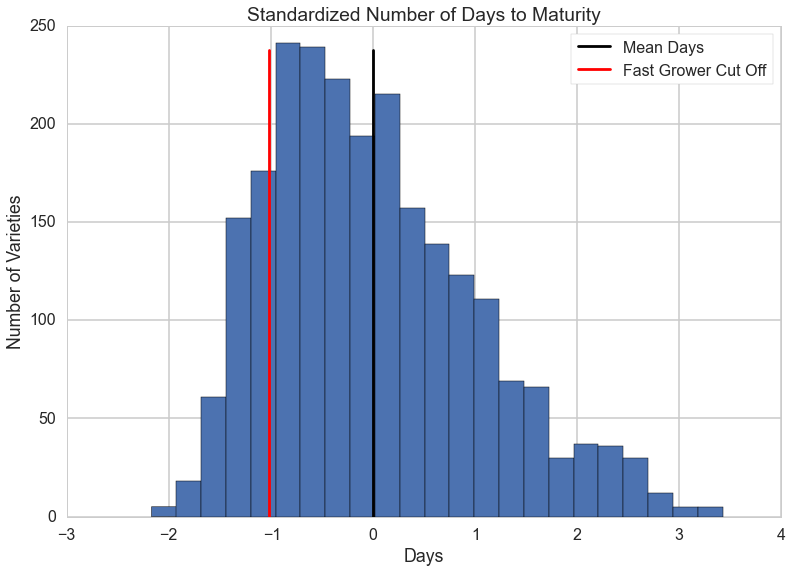

In [522]:
# Plot standardized days to maturity
plt.hist(mat_df['stdardized_mat'], bins=23);
plt.title('Standardized Number of Days to Maturity')
plt.xlabel('Days')
plt.ylabel('Number of Varieties');
plt.axvline(np.mean(mat_df['stdardized_mat']), label='Mean Days', color='black',ymax=.95)
plt.axvline(np.mean(mat_df['stdardized_mat'])-np.std(mat_df['stdardized_mat']), 
            label='Fast Grower Cut Off',color='red',ymax=.95)
plt.legend(frameon=True);

We see how many are fast as because this is a discreet, not truely continous variable, the `fast` cutoff isn't exact.

In [524]:
print "% fast: " + str(sum(mat_df['fast'])/float(len((mat_df['fast']))) * 100)
print "% slow: " + str((1. -sum(mat_df['fast'])/float(len((mat_df['fast'])))) * 100)

% fast: 15.1023890785
% slow: 84.8976109215


This means, as a baseline, that we can achieve approximately **84.89% accuracy** if we *always* predict the rice to be a slow grower. Thus 84.89% is the accuracy to beat!

### Strain Baseline

It is quite reasonable to assume that strains more closely related to one another will have similar growth times (much as people who are more closely related have similar phenotypic features). Assuming there is variation between variety groups, we introduce the concept of a variety mean here to start our first features based prediction (NOTE: Because variety is a categorical variable of few options, it appears of all types in the mask and train, this is not the case for source country which we use later, and as such will treat the two variables slightly differently):

In [525]:
variety_days = {}

# iterate through the index taking the variety and days to mat
for idx, row in enumerate(mat_df[mask].index):
    variety = mat_df[mask].iloc[idx]['Variety Group (Tree)1']
    days = mat_df[mask].iloc[idx]['days_to_mat']
    
    # create an entry in the dict if not present as [days]
    if variety not in variety_days.keys():
        variety_days.update({variety:[days]})
    # append days to list if it exists
    else:
        variety_days.get(variety).append(days)

# collapse all to the variety mean
for key in variety_days.keys():
    days = np.mean(variety_days.get(key))
    variety_days.update({key:days})
    
variety_days

{'Aus/boro': 113.38194444444444,
 'Basmati/sadri': 127.77500000000001,
 'Indica': 138.90221774193549,
 'Intermediate type': 129.09615384615384,
 'Japonica': 129.23287671232876,
 'Temperate japonica': 111.53703703703704,
 'Tropical japonica': 125.32034632034632}

As expected, the different varietal groups were different in their mean days to maturity. Indica strains took the longest on average while Temperate Japonica strains took the shortest.

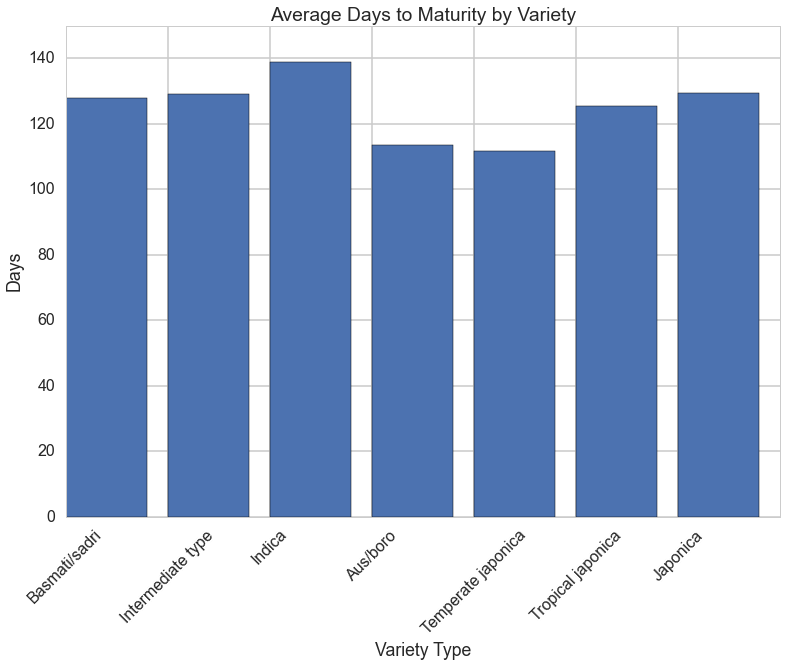

In [526]:
# Plot days to mat by variety
plt.bar(xrange(0,len(variety_days.values())),variety_days.values());
plt.title('Average Days to Maturity by Variety');
plt.ylabel('Days');
plt.xlabel('Variety Type');
plt.axis([0,7,0,150])
plt.xticks(xrange(0,len(variety_days.values())),(variety_days.keys()),rotation='45',);

We define a very simple model giving equal weight to the global mean and the variety mean:

$$ \hat Y^{baseline}_{u} = (\bar Y + \bar Y_u)/2$$

where $\bar Y_u$ = `strain_average`, the average of all groups $u$'s `days_to_mat` and $\bar Y$ is the average days to maturity of all strains

In [527]:
from sklearn.metrics import confusion_matrix

a = []
b = []

# iterate through df, find variety, predict based on equal weigthing 
for row in enumerate(mat_df[~mask].index):
    variety = mat_df[~mask].iloc[row[0]]['Variety Group (Tree)1']
    pred = (0.5*days_list.mean() + 0.5*variety_days.get(variety))
    
    # if prediction is below cut off, call fast
    if pred < (days_list.mean() - days_list.std()):
        a.append(True)
    else:
        a.append(False)
    b.append(pred)

# determine confusion matrix
conf = confusion_matrix(mat_df[~mask]['fast'], a)
        
print conf
print "Accuracy: " + str(float(conf[0][0]+conf[1][1])/float(len(mat_df[~mask]))*100) + "%"

[[585   0]
 [119   0]]
Accuracy: 83.0965909091%


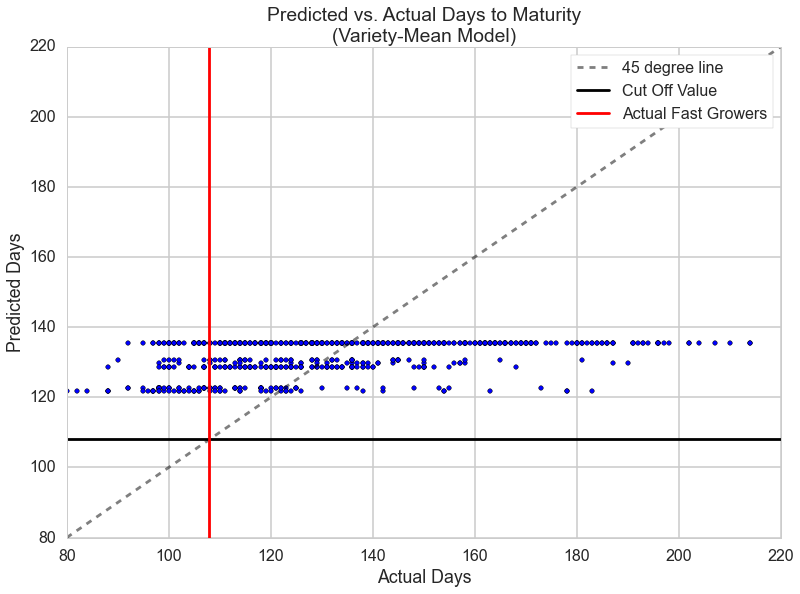

In [528]:
# plot the predicted values from the model against the true days to mat
cutoff = (days_list.mean() - days_list.std())
plt.scatter(mat_df[~mask]['days_to_mat'],b);
plt.title('Predicted vs. Actual Days to Maturity\n(Variety-Mean Model)');
plt.xlabel('Actual Days');
plt.ylabel('Predicted Days');
plt.plot([80,220],[80,220],'k--', alpha=0.5, label='45 degree line');
plt.axis([80,220,80,220]);
plt.axhline(cutoff, color='black',label='Cut Off Value');
plt.axvline(cutoff, color='r',label='Actual Fast Growers');
plt.legend(frameon=True);

This predicted an accuracy of 83% - the decrease from the initial baseline is most likely due to variation in the train/test splitting. As is clear from the confusion matrix, the model predicted only negatives (aka slow growers). Looking at the scatter plot, ideally the plot would be along the 45 degree line, yet this model only predicted based upon global mean and varietal group average, thus every strain within a group has the same prediction (producing the flat lines). All data is above the cut off value (this indicates negative predictions) and roughly 17% is to the left of the actual fast growers line (aka false negatives). 

### Strain-Country Baseline Regression

Now we begin to complicate the model by introducing the concept of country averages. This makes sense to include as climactic differences between various areas might impact how fast the strains grow (environmental effect on phenotype). For instance a rice strain might mature slower in colder climates or how much rainfall hits an area might also have an effect. As such we move forward to add nuance to our feature based modeling:

In [551]:
source_days = {}

# iterate through the df, taking note of the source country and days to mat
for idx, row in enumerate(mat_df[mask].index):
    source = mat_df[mask].iloc[idx]['source_country']
    days = mat_df[mask].iloc[idx]['days_to_mat']
    
    # if it doesnt exist in the dict, add the [days], creating an entry
    if source not in source_days.keys():
        source_days.update({source:[days]})
    # otherwise append to the list
    else:
        source_days.get(source).append(days)
        
# collapse the lists to just the mean
for key in source_days.keys():
    days = np.mean(source_days.get(key))
    num = len(source_days.get(key))
    source_days.update({key:(days,num)})

# print a sample
print "Country: " + str(source_days.keys()[2])
print "Avg. Days: " + str(source_days.get(source_days.keys()[2])[0])
print "Strains from Country: " + str(source_days.get(source_days.keys()[2])[1])

Country: COLOMBIA
Avg. Days: 122.384615385
Strains from Country: 13


Out of curiousity we see how frequently strains appear:

Max: 281
Min: 1
Mean: 19.7590361446


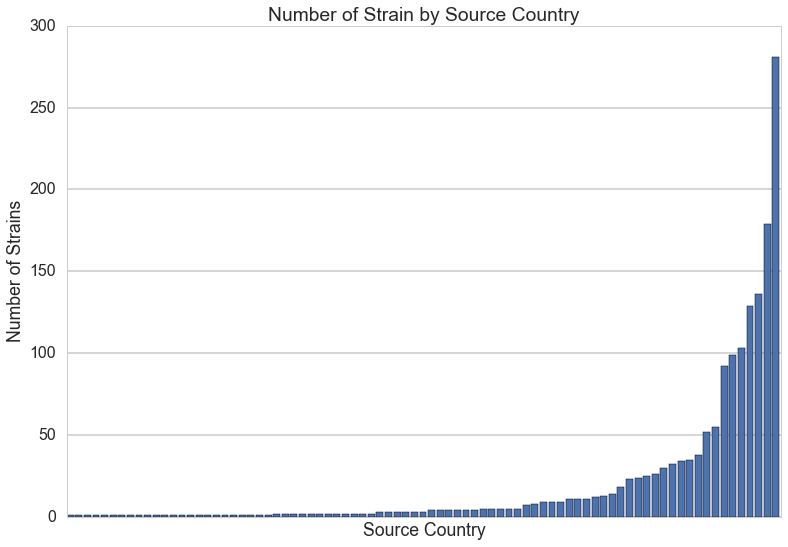

In [552]:
# Plot # strains per country
a = (np.sort([source_days.get(source)[1] for source in source_days]))
print "Max: " + str(a[-1])
print "Min: " + str(a[0])
print "Mean: " + str(np.mean(a))
plt.bar(xrange(0,len(a)),a);
plt.axis([0,len(a),0,300])
plt.title('Number of Strain by Source Country');
plt.ylabel('Number of Strains');
plt.xlabel('Source Country');
plt.xticks([]);

We also see how the days might vary by country:

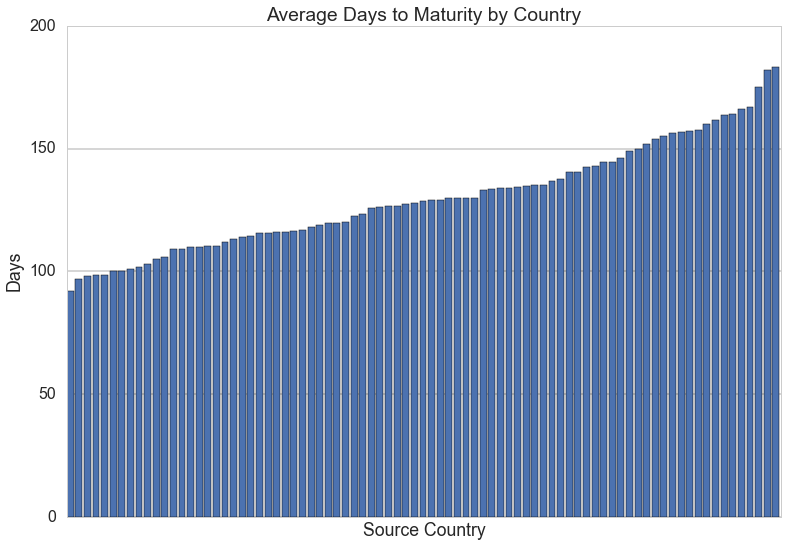

In [550]:
a = np.sort([source_days.get(source)[0] for source in source_days])
plt.bar(xrange(0,len(a)),a);
plt.axis([0,len(a),0,200])
plt.title('Average Days to Maturity by Country');
plt.ylabel('Days');
plt.xlabel('Source Country');
plt.xticks([]);

We were right in our assumption that various source countries have differing values. This is probably due to both an environmental effect as well as the fact that strains are more likely to be closer related the closer they are geographically to one another as rice is not very migrant and thus alleles are slow to travel from one population to another (closest strains will most likely be closest geographically). As such we are planning to use this variable in an basic, updated model:

$$ \hat Y^{baseline}_{um} = \bar Y_m | (\bar Y + \bar Y_u)/2$$

where $\bar Y_u$ = `var_acg`, the average of all variety $u$'s `days_to_mat`, $\bar Y_m$ = `country_average`, the average of all country $m$'s `days_to_mat`  and $\bar Y$ is the average days to maturity of all strains. Note: ' | ' here stands if it exits, use $\bar Y_m$ ELSE use initial group-total mean equal weight  model

In [554]:
a = []
b = []

# Print days to beat
print (days_list.mean() - days_list.std())

# Iterate throught the df getting source and variety
for row in enumerate(mat_df[~mask].index):
    variety = mat_df[~mask].iloc[row[0]]['Variety Group (Tree)1']
    source = mat_df[~mask].iloc[row[0]]['source_country']
    
    # if source is in the source dict, use it's mean 
    if source in source_days.keys():
        pred = (source_days.get(source)[0])
    # else use initial prediction 
    else:
        pred = (days_list.mean()+variety_days.get(variety))/2
    
    # if below cut off true
    if pred < (days_list.mean() - days_list.std()):
        a.append(True)
    else:
        a.append(False)
    b.append(pred)
# print confusion matrix
conf = confusion_matrix(mat_df[~mask]['fast'], a)
    
print conf
print "Accuracy: " + str(float(conf[0][0]+conf[1][1])/float(len(mat_df[~mask]))*100) + "%"

107.9890154
[[582   3]
 [106  13]]
Accuracy: 84.5170454545%


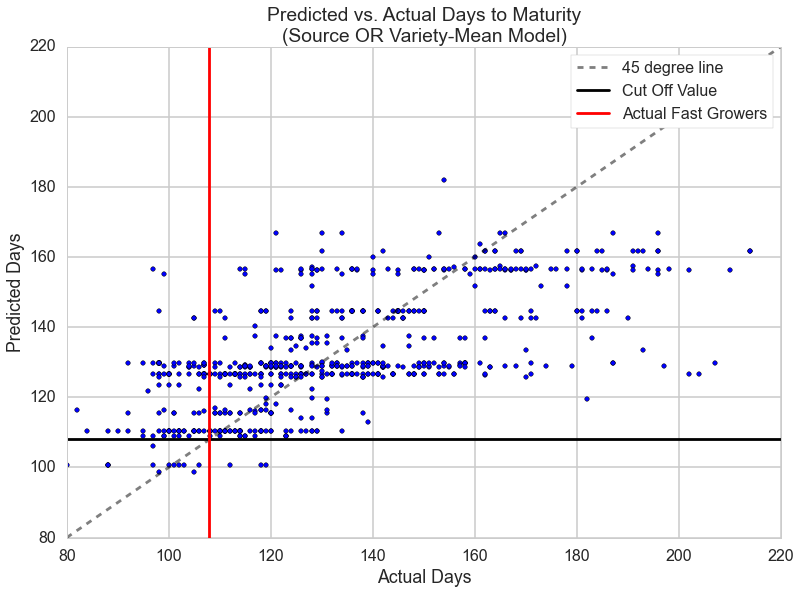

In [555]:
# Plot predicted days to mat on this model vs actual
plt.scatter(mat_df[~mask]['days_to_mat'],b);
plt.title('Predicted vs. Actual Days to Maturity\n(Source OR Variety-Mean Model)');
plt.xlabel('Actual Days');
plt.ylabel('Predicted Days');
plt.plot([80,220],[80,220],'k--', alpha=0.5, label='45 degree line');
plt.axis([80,220,80,220]);
plt.axhline(cutoff, color='black',label='Cut Off Value');
plt.axvline(cutoff, color='r',label='Actual Fast Growers');
plt.legend(frameon=True);

This predicted an accuracy of 84.5% - an increase in our predictive power! The confusion matrix shows that this model produced TP,TN,FP,FP, which is more interesting than the earlier, always predict negative model. It still tended to disproportionately predict negaitvely though. Looking at the scatter plot, ideally the plot would be along the 45 degree line, yet this model predicted on EITHER source country or global mean and varietal group average, thus every strain within a country has the same prediction (producing the flat lines) in common countries or in all of a variety group with uncommon countries, with the additional scattering of small (uncommon countries). This data is scattered across the quadrants fairly well, but most data is above the prediction cut off. 

We move on to preform a regression on the country / variety group / global means to see if this predicts better, creating a new df that contains columns for the variety, source and global means for each row based on their features, setting source val to the global mean if it is not in the source dict:

This will use the formula:

$$ \hat Y_{um}^{baseline} = \hat \mu * \bar Y + \hat \theta_{u} * \bar Y_u  + \hat \gamma_{m} * \bar Y_m  + I$$

where $\hat \mu$ is the the correlation of average days for all strains, $\bar Y$ is the mean days for all strains, $\theta_{u}$ = correlation of the varieties, $\bar Y_u$ is the average of variety group $u$'s days, $\hat \gamma_{m}$ is the correlation of the source countries, $\bar Y_m$ = is the average days for a source country $m$, and I is an intercept value.

In [556]:
train_df = mat_df[mask]

train_var_days = []
train_source_days = []

# iterate through rows, getting the source and variety group
for row,_ in enumerate(train_df.index):
    var = train_df.iloc[row]['Variety Group (Tree)1']
    source = train_df.iloc[row]['source_country']
    
    # for those in the source dict, get that average
    if source in source_days.keys():
        train_source_days.append((source_days.get(source)[0]))
        
    # otherwise set source average to the global mean
    else:
        train_source_days.append(days_list.mean())
        
    # in the var dict append variety 
    train_var_days.append((variety_days.get(var)))

# add columbs based on these for the OLS model
train_df.loc[:,'source_val'] = train_source_days
train_df.loc[:,'var_val'] = train_var_days
train_df.loc[:,'mean'] = days_list.mean()

train_df.head(10)

,DNA_UNIQUE_ID,Variety Group (Tree)1,days_to_mat,source_country,stdardized_mat,fast,source_val,var_val,mean
0,IRIS 313-9783,Japonica,110,AFGHANISTAN,-0.916015,False,110.000000,129.232877,131.933537
1,IRIS 313-10509,Indica,164,AFRICA,1.339198,False,164.000000,138.902218,131.933537
2,IRIS 313-9778,Indica,119,ARGENTINA,-0.540146,False,114.500000,138.902218,131.933537
3,IRIS 313-9980,Japonica,110,ARGENTINA,-0.916015,False,114.500000,129.232877,131.933537
4,IRIS 313-9795,Indica,135,AUSTRALIA,0.128065,False,135.000000,138.902218,131.933537
5,IRIS 313-9771,Tropical japonica,119,AUSTRIA,-0.540146,False,119.000000,125.320346,131.933537
6,IRIS 313-11482,Aus/boro,133,BANGLADESH,0.044539,False,129.782946,113.381944,131.933537
7,IRIS 313-11481,Aus/boro,118,BANGLADESH,-0.581909,False,129.782946,113.381944,131.933537
8,IRIS 313-11483,Aus/boro,107,BANGLADESH,-1.041304,True,129.782946,113.381944,131.933537
9,IRIS 313-11048,Aus/boro,98,BANGLADESH,-1.417173,True,129.782946,113.381944,131.933537


In [557]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols

ols_model = ols('days_to_mat ~ source_val + var_val + mean', train_df).fit()
ols_model.params

Intercept    -0.003961
source_val    0.896937
var_val       0.625699
mean         -0.522606
dtype: float64

Training the OLS model, we see that `source_val` is weighted more heavily than the `var_val` in predicting. Perhaps this is due to the more nuanced data (more categories, etc). We now run the model on the test data:

In [559]:
a = []
b = []
mean = days_list.mean()

# iterate through the not mask getting variety and source
for row in enumerate(mat_df[~mask].index):
    variety = mat_df[~mask].iloc[row[0]]['Variety Group (Tree)1']
    source = mat_df[~mask].iloc[row[0]]['source_country']
   
    # if source exitsts, use this full correlation that OLS produced
    if source in source_days.keys():
        pred = (ols_model.params.Intercept + ols_model.params.source_val*source_days.get(source)[0]
        + ols_model.params.var_val*variety_days.get(variety) + ols_model.params['mean']*mean)
    # else, use global mean in place of the souce average
    else:
        pred = (ols_model.params.Intercept + ols_model.params.source_val*mean
        + ols_model.params.var_val*variety_days.get(variety) + ols_model.params['mean']*mean)

    # if below cutoff, predict true
    if pred < (days_list.mean() - days_list.std()):
        a.append(True)
    else:
        a.append(False)
    b.append(pred)
# get confusion matrix
conf = confusion_matrix(mat_df[~mask]['fast'], a)
    
print conf
print "Accuracy: " + str(float(conf[0][0]+conf[1][1])/float(len(mat_df[~mask]))*100) + "%"

[[569  16]
 [ 90  29]]
Accuracy: 84.9431818182%


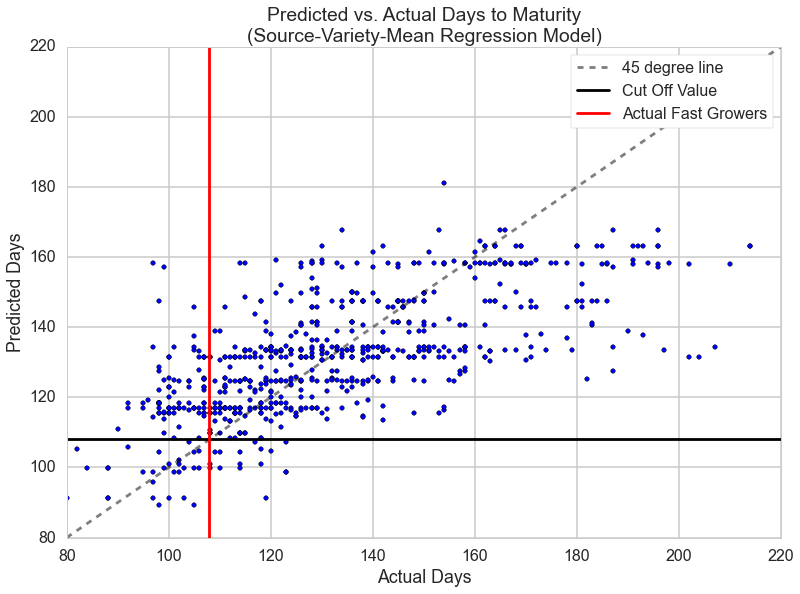

In [560]:
plt.scatter(mat_df[~mask]['days_to_mat'],b);
plt.title('Predicted vs. Actual Days to Maturity\n(Source-Variety-Mean Regression Model)');
plt.xlabel('Actual Days');
plt.ylabel('Predicted Days');
plt.plot([80,220],[80,220],'k--', alpha=0.5, label='45 degree line');
plt.axis([80,220,80,220]);
plt.axhline(cutoff, color='black',label='Cut Off Value');
plt.axvline(cutoff, color='r',label='Actual Fast Growers');
plt.legend(frameon=True);

Our efforts paid off! This model predicted an accuracy of 84.9% - an increase in our predictive power! The confusion matrix shows that this model produced TP,TN,FP,FP, with more than twice the true positives than the last model. It still tended to disproportionately predict negaitvely though. Looking at the scatter plot, ideally the plot would be along the 45 degree line. This model only was using 2 features and the global mean to predict, but managed to produce some interesting results. As it turns out there is some horizontal linearity, probably due to more strains of a given variety group existing in the same country. The data is the best yet in terms of being scattered across the quandrants.

We move on to preform the same regression on the country / variety group / global means, but this time using the normalized `stddadized_mat` to see if this predicts better.

This will use the formula:

$$ \hat Y_{um}^{baseline} = \hat \mu * \bar Y + \hat \theta_{u} * \bar Y_u  + \hat \gamma_{m} * \bar Y_m  + I$$

where $\hat \mu$ is the the correlation of standardized average days for all strains, $\bar Y$ is the mean days for all strains, $\theta_{u}$ = correlation of the varieties, $\bar Y_u$ is the standardized average of variety group $u$'s days, $\hat \gamma_{m}$ is the correlation of the source countries and $\bar Y_m$ = is the standardized average days for a source country $m$, and I is an intercept value.

### Normalized Strain-Country Baseline Regression

In [561]:
stddays_list = [item for item in mat_df[mask]['stdardized_mat']]
stdmean = np.mean(stddays_list)

stdvariety_days = {}

# analogous to before, get average standardized days to maturity for the varietal groups
for idx, row in enumerate(mat_df[mask].index):
    variety = mat_df[mask].iloc[idx]['Variety Group (Tree)1']
    days = mat_df[mask].iloc[idx]['stdardized_mat']
    if variety not in stdvariety_days.keys():
        stdvariety_days.update({variety:[days]})
    else:
        stdvariety_days.get(variety).append(days)
for key in stdvariety_days.keys():
    days = np.mean(stdvariety_days.get(key))
    stdvariety_days.update({key:days})
    
stdsource_days = {}

# analogous to before, get average standardized days to maturity for the countries 
for idx, row in enumerate(mat_df[mask].index):
    source = mat_df[mask].iloc[idx]['source_country']
    days = mat_df[mask].iloc[idx]['stdardized_mat']
    if source not in stdsource_days.keys():
        stdsource_days.update({source:[days]})
    else:
        stdsource_days.get(source).append(days)
for key in stdsource_days.keys():
    days = np.mean(stdsource_days.get(key))
    num = len(stdsource_days.get(key))
    stdsource_days.update({key:(days,num)})

    
# iterate through the training df, get the source and country putting in std_source and std_var as columns
stdtrain_var_days = []
stdtrain_source_days = []
for row,_ in enumerate(train_df.index):
    var = train_df.iloc[row]['Variety Group (Tree)1']
    source = train_df.iloc[row]['source_country']
    if source in stdsource_days.keys():
        stdtrain_source_days.append((stdsource_days.get(source)[0]))
    else:
        stdtrain_source_days.append(0)
    stdtrain_var_days.append((stdvariety_days.get(var)))
    
train_df.loc[:,'stdsource_val'] = (stdtrain_source_days)
train_df.loc[:,'stdvar_val'] = (stdtrain_var_days)
train_df.loc[:,'mean'] = days_list.mean()
# standardized mean = 0 as the system is set to mean 0
train_df.loc[:,'std_mean'] = 0

Checking out how the standardized values spread by country, we see, perhaps more so than before, the variance between countries and their average days to maturity:

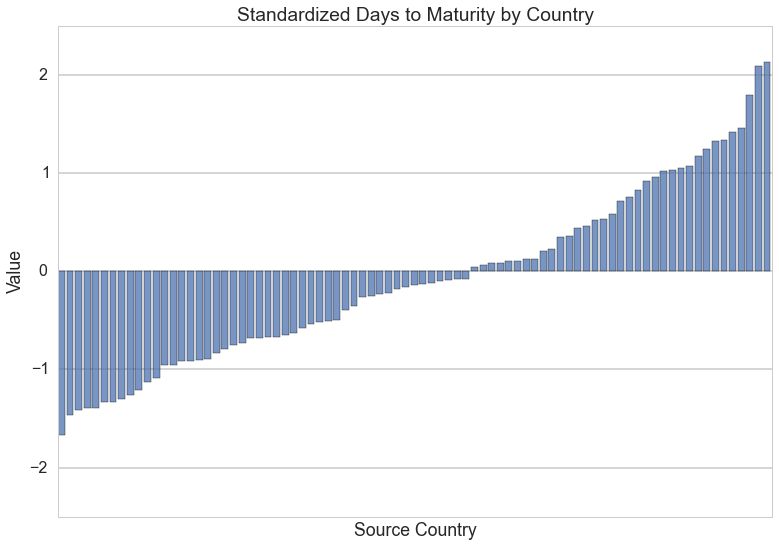

In [563]:
a = np.sort([stdsource_days.get(source)[0] for source in stdsource_days])
plt.bar(xrange(0,len(a)),a, alpha=.75);
plt.axis([0,len(a),-2.5,2.5]);
plt.title('Standardized Days to Maturity by Country');
plt.ylabel('Value');
plt.xlabel('Source Country');
plt.xticks([]);

In [564]:
stdols_model = ols('stdardized_mat ~ stdsource_val + stdvar_val + std_mean', train_df).fit()
stdols_model.params

Intercept       -1.327063e-16
stdsource_val    8.969370e-01
stdvar_val       6.256993e-01
std_mean         0.000000e+00
dtype: float64

Training the OLS model, we see that `stdsource_val` is weighted more heavily than the `stdvar_val` in predicting. Perhaps this is due to the more nuanced data (more categories, etc). We now run the model on the test data:

In [565]:
a = []
b=[]

for row in enumerate(mat_df[~mask].index):
    variety = mat_df[~mask].iloc[row[0]]['Variety Group (Tree)1']
    source = mat_df[~mask].iloc[row[0]]['source_country']
    
    if source in stdsource_days.keys():
        pred = (stdols_model.params.Intercept + stdols_model.params.stdsource_val*stdsource_days.get(source)[0]
        + stdols_model.params.stdvar_val*stdvariety_days.get(variety))
   
    else:
        pred = (stdols_model.params.Intercept + stdols_model.params.stdvar_val*stdvariety_days.get(variety))

    if pred < (0 - np.std(stddays_list)):
        a.append(True)
    else:
        a.append(False)
    b.append(pred)
conf = confusion_matrix(mat_df[~mask]['fast'], a)
    
print conf
print "Accuracy: " + str(float(conf[0][0]+conf[1][1])/float(len(mat_df[~mask]))*100) + "%"

[[569  16]
 [ 90  29]]
Accuracy: 84.9431818182%


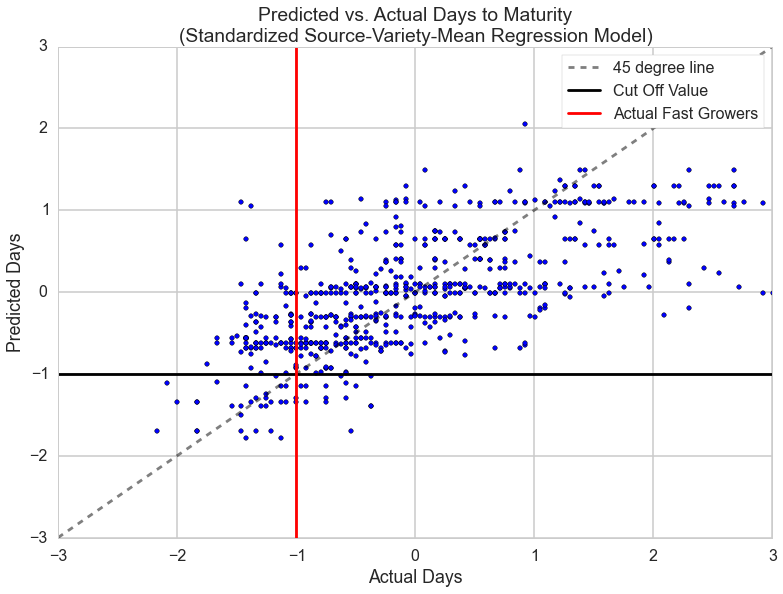

In [566]:
plt.scatter(mat_df[~mask]['stdardized_mat'],b);
plt.title('Predicted vs. Actual Days to Maturity\n(Standardized Source-Variety-Mean Regression Model)');
plt.xlabel('Actual Days');
plt.ylabel('Predicted Days');
plt.plot([-3,3],[-3,3],'k--', alpha=0.5, label='45 degree line');
plt.axis([-3,3,-3,3]);
plt.axhline(-1, color='black',label='Cut Off Value');
plt.axvline(-1, color='r',label='Actual Fast Growers');
plt.legend(frameon=True);

Our efforts paid off! This model predicted an accuracy of 84.9% - the same predictive power as the last model. The confusion matrix shows that this model produced TP,TN,FP,FP, with good spread between the groups. It still tended to disproportionately predict negaitvely though. Looking at the scatter plot, ideally the plot would be along the 45 degree line. This model only was using 2 features and the global mean to predict, but managed to produce some interesting results. As it turns out there is some horizontal linearity, probably due to more strains of a given variety group existing in the same country. The data is the best yet in terms of being scattered across the quandrants.

With that, while theres perhaps much more feature analysis that could be done, we decieded source country and varietal group were fine to end with as these are easily obtainable points that are understandably correlated with days to maturity for the genetic and environmental aspects. Variables such as altitude etc could further this feature analysis, however, we decided it was time to move on to SNP data.

## Accessing SNP Data

<img src="https://www.broadinstitute.org/files/news/stories/full/SNP_260x260.jpg" width=200 height=300/>
Image from: https://www.broadinstitute.org/files/news/stories/full/SNP_260x260.jpg

### Accessing Process

The SNP data was downwloaded as PED and MAP files from https://s3.amazonaws.com/3kricegenome/reduced/NB-core_v4.ped.gz and https://s3.amazonaws.com/3kricegenome/reduced/NB-core_v4.map.gz. These files were then converted to a VCF file using plink 1.9 (can be downloaded at https://www.cog-genomics.org/plink2) with the terminal command `command: ./plink --file tempdata/NB-core_v4 --recode vcf`. This was done to make the data in a format compatible with the PyVCF package. The VCF file was over 12 GB, so we could not include it in the repository.

### Database Construction

TEXT

In [ ]:
vcf_reader=vcf.Reader(open('tempdata/plink.vcf', 'r'))

In [ ]:
#create counter
i = 0
#create dataframe to hold snp data with samples as columns
snpdf=pd.DataFrame(columns=vcf_reader.samples)
#create default dict list to hold snps
snps = defaultdict(list)
#create array to hold index values
ind_array=[]
#iterate through every snp
for snp in vcf_reader:
    #create a location string containing chromosome and position
    loc=(str(snp.CHROM)+'_'+str(snp.POS))
    #add loc string to ind_array
    ind_array.append(loc)
    #increase counter
    i = i+1
    #go through every sample for snp
    for sample in (snp.samples):
        #add sample name as key and genotype as value to snps dict
        snps[sample.sample].append(sample.data.GT)
    if (i % 1000) == 0:
        #create dataframe from snps dict
        df=pd.DataFrame.from_dict(snps)
        #set index column of dataframe to be ind_array
        df['index']=ind_array
        #set index to index column
        df=df.set_index('index')
        #remove name of index
        df.index.name = None
        #add dataframe to full snp dataframe
        snpdf=snpdf.append(df)
        #reset snps dict
        snps={}
        snps = defaultdict(list)
        #reset ind_array
        ind_array=[]
    if (i%50000)==0:
        #create csv of 50,000 snps
        name=('tempdata/snps'+str(i/50000)+'.csv')
        snpdf.to_csv(name)
        #reset dataframe
        snpdf=pd.DataFrame(columns=vcf_reader.samples)
        print 'created' + str(name)
#save final snp data to csv
snpdf.to_csv('tempdata/snps20.csv')

`CPU times: user 6h 56min 47s, sys: 11min 6s, total: 7h 7min 53s, Wall time: 7h 9min 33s`

These 20 CSV files created from the VCF file abover were each over 500 MB in size, so we were unable to include them in our repository. However, they can be downloaded within a compressed file from this Dropbox link: https://www.dropbox.com/sh/orgk51k8pgka69p/AABRBRvb9gDQgRtcuKKLYVnZa?dl=0.

TEXT

### EDA of SNP Data

In [567]:
snpedadf= pd.read_csv('tempdata/snps1.csv', index_col=0)
print snpedadf.shape
snpedadf.head()

(50000, 3023)


,B001_B001,B002_B002,B003_B003,B004_B004,B005_B005,B006_B006,B007_B007,B008_B008,B009_B009,B010_B010,B011_B011,B012_B012,B013_B013,B014_B014,B015_B015,B016_B016,B017_B017,B018_B018,B019_B019,B020_B020,B021_B021,B023_B023,B024_B024,B025_B025,B026_B026,B027_B027,B028_B028,B029_B029,B030_B030,B031_B031,B032_B032,B033_B033,B034_B034,B035_B035,B036_B036,B037_B037,B038_B038,B039_B039,B040_B040,B043_B043,B044_B044,B045_B045,B046_B046,B047_B047,B048_B048,B049_B049,B051_B051,B052_B052,B053_B053,B054_B054,...,IRIS_313-9822_IRIS_313-9822,IRIS_313-9825_IRIS_313-9825,IRIS_313-9831_IRIS_313-9831,IRIS_313-9832_IRIS_313-9832,IRIS_313-9838_IRIS_313-9838,IRIS_313-9839_IRIS_313-9839,IRIS_313-9841_IRIS_313-9841,IRIS_313-9851_IRIS_313-9851,IRIS_313-9861_IRIS_313-9861,IRIS_313-9862_IRIS_313-9862,IRIS_313-9867_IRIS_313-9867,IRIS_313-9880_IRIS_313-9880,IRIS_313-9882_IRIS_313-9882,IRIS_313-9884_IRIS_313-9884,IRIS_313-9886_IRIS_313-9886,IRIS_313-9887_IRIS_313-9887,IRIS_313-9890_IRIS_313-9890,IRIS_313-9891_IRIS_313-9891,IRIS_313-9897_IRIS_313-9897,IRIS_313-9898_IRIS_313-9898,IRIS_313-9917_IRIS_313-9917,IRIS_313-9922_IRIS_313-9922,IRIS_313-9924_IRIS_313-9924,IRIS_313-9925_IRIS_313-9925,IRIS_313-9926_IRIS_313-9926,IRIS_313-9928_IRIS_313-9928,IRIS_313-9929_IRIS_313-9929,IRIS_313-9935_IRIS_313-9935,IRIS_313-9936_IRIS_313-9936,IRIS_313-9937_IRIS_313-9937,IRIS_313-9939_IRIS_313-9939,IRIS_313-9940_IRIS_313-9940,IRIS_313-9944_IRIS_313-9944,IRIS_313-9949_IRIS_313-9949,IRIS_313-9953_IRIS_313-9953,IRIS_313-9961_IRIS_313-9961,IRIS_313-9963_IRIS_313-9963,IRIS_313-9964_IRIS_313-9964,IRIS_313-9966_IRIS_313-9966,IRIS_313-9968_IRIS_313-9968,IRIS_313-9969_IRIS_313-9969,IRIS_313-9970_IRIS_313-9970,IRIS_313-9974_IRIS_313-9974,IRIS_313-9976_IRIS_313-9976,IRIS_313-9978_IRIS_313-9978,IRIS_313-9980_IRIS_313-9980,IRIS_313-9986_IRIS_313-9986,IRIS_313-9989_IRIS_313-9989,IRIS_313-9995_IRIS_313-9995,IRIS_313-9996_IRIS_313-9996
1_1203,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1/1,1/1,1/1,NaN,0/0,0/0,1/1,0/0,0/0,0/0,0/0,0/0,1/1,0/0,0/0,0/0,1/1,0/0,1/1,NaN,NaN,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,NaN,1/1,0/0,0/0,0/0,0/0,0/0,0/0,1/1,0/0,0/0,0/1,NaN,...,0/0,0/0,1/1,1/1,0/0,0/0,0/0,0/0,1/1,1/1,0/0,0/0,1/1,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,NaN,0/0,NaN,0/0,0/0,0/0,0/0,1/1,0/0,0/0,0/0,1/1,0/0,0/0,1/1,1/1,1/1,0/0,1/1,NaN,0/0,0/0,0/0,0/0,0/0
1_1248,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,NaN,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,NaN,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
1_1282,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,NaN,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
1_1299,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1/1,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,NaN,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1/1,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
1_1787,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0


In [568]:
snpedadf = snpedadf.replace(['0/0', '0/1', '1/1', np.nan], [0, 1, 2, 3])
snpedadf.head()

,B001_B001,B002_B002,B003_B003,B004_B004,B005_B005,B006_B006,B007_B007,B008_B008,B009_B009,B010_B010,B011_B011,B012_B012,B013_B013,B014_B014,B015_B015,B016_B016,B017_B017,B018_B018,B019_B019,B020_B020,B021_B021,B023_B023,B024_B024,B025_B025,B026_B026,B027_B027,B028_B028,B029_B029,B030_B030,B031_B031,B032_B032,B033_B033,B034_B034,B035_B035,B036_B036,B037_B037,B038_B038,B039_B039,B040_B040,B043_B043,B044_B044,B045_B045,B046_B046,B047_B047,B048_B048,B049_B049,B051_B051,B052_B052,B053_B053,B054_B054,...,IRIS_313-9822_IRIS_313-9822,IRIS_313-9825_IRIS_313-9825,IRIS_313-9831_IRIS_313-9831,IRIS_313-9832_IRIS_313-9832,IRIS_313-9838_IRIS_313-9838,IRIS_313-9839_IRIS_313-9839,IRIS_313-9841_IRIS_313-9841,IRIS_313-9851_IRIS_313-9851,IRIS_313-9861_IRIS_313-9861,IRIS_313-9862_IRIS_313-9862,IRIS_313-9867_IRIS_313-9867,IRIS_313-9880_IRIS_313-9880,IRIS_313-9882_IRIS_313-9882,IRIS_313-9884_IRIS_313-9884,IRIS_313-9886_IRIS_313-9886,IRIS_313-9887_IRIS_313-9887,IRIS_313-9890_IRIS_313-9890,IRIS_313-9891_IRIS_313-9891,IRIS_313-9897_IRIS_313-9897,IRIS_313-9898_IRIS_313-9898,IRIS_313-9917_IRIS_313-9917,IRIS_313-9922_IRIS_313-9922,IRIS_313-9924_IRIS_313-9924,IRIS_313-9925_IRIS_313-9925,IRIS_313-9926_IRIS_313-9926,IRIS_313-9928_IRIS_313-9928,IRIS_313-9929_IRIS_313-9929,IRIS_313-9935_IRIS_313-9935,IRIS_313-9936_IRIS_313-9936,IRIS_313-9937_IRIS_313-9937,IRIS_313-9939_IRIS_313-9939,IRIS_313-9940_IRIS_313-9940,IRIS_313-9944_IRIS_313-9944,IRIS_313-9949_IRIS_313-9949,IRIS_313-9953_IRIS_313-9953,IRIS_313-9961_IRIS_313-9961,IRIS_313-9963_IRIS_313-9963,IRIS_313-9964_IRIS_313-9964,IRIS_313-9966_IRIS_313-9966,IRIS_313-9968_IRIS_313-9968,IRIS_313-9969_IRIS_313-9969,IRIS_313-9970_IRIS_313-9970,IRIS_313-9974_IRIS_313-9974,IRIS_313-9976_IRIS_313-9976,IRIS_313-9978_IRIS_313-9978,IRIS_313-9980_IRIS_313-9980,IRIS_313-9986_IRIS_313-9986,IRIS_313-9989_IRIS_313-9989,IRIS_313-9995_IRIS_313-9995,IRIS_313-9996_IRIS_313-9996
1_1203,0,0,0,0,0,0,0,0,2,2,2,3,0,0,2,0,0,0,0,0,2,0,0,0,2,0,2,3,3,0,0,0,0,0,0,0,0,3,2,0,0,0,0,0,0,2,0,0,1,3,...,0,0,2,2,0,0,0,0,2,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,2,0,0,0,2,0,0,2,2,2,0,2,3,0,0,0,0,0
1_1248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
1_1787,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [569]:
index_uniques = []
for row in snpedadf.iterrows():
    index_uniques.append(np.bincount(row[1].values))
index_uniques[:3]

[array([2004,   37,  642,  340]),
 array([2827,    4,   68,  124]),
 array([2893,    1,   30,   99])]

NaN: 8.58952100562 %


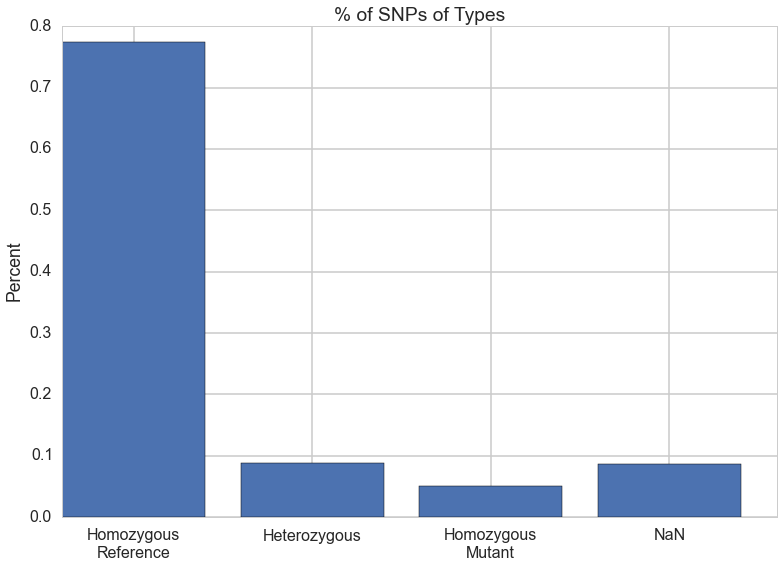

In [570]:
pltter=[]
for index in index_uniques:
    if len(index) == 4:
          pltter.append(index)
            
a = [float(arr[0]) for arr in pltter]
b = [float(arr[1]) for arr in pltter]
c = [float(arr[2]) for arr in pltter]
d = [float(arr[3]) for arr in pltter]
count = float((len(snpedadf.columns)*len(snpedadf.index)))

pcents = [(np.sum(a)/count),(np.sum(b)/count),(np.sum(c)/count),(np.sum(d)/count)]
plt.bar(xrange(0,4),pcents);
plt.title('% of SNPs of Types');
plt.ylabel('Percent');
plt.xticks([.4,1.4,2.4,3.4],['Homozygous\nReference','Heterozygous','Homozygous\nMutant','NaN'],rotation='0',);
print "NaN: " + str((np.sum(d)/count)*100) + " %"

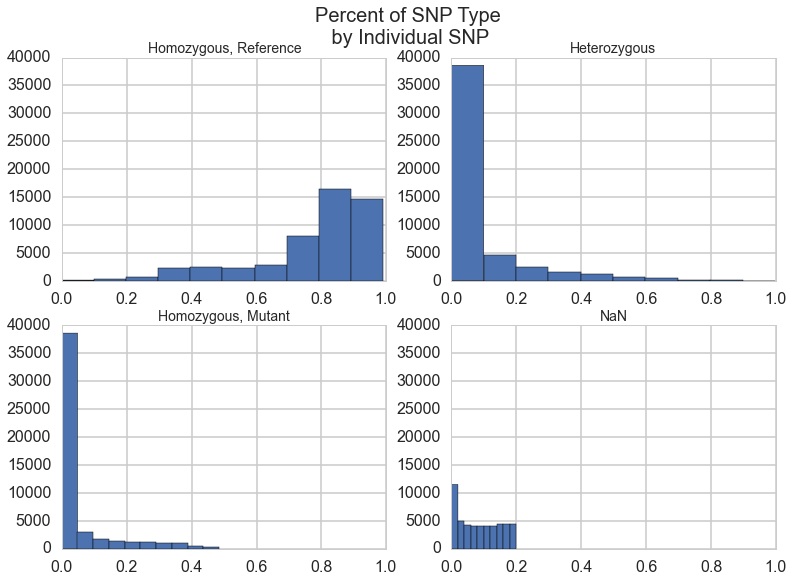

In [571]:
a = [float(arr[0])/float(len(snpedadf.columns)) for arr in pltter]
b = [float(arr[1])/float(len(snpedadf.columns)) for arr in pltter]
c = [float(arr[2])/float(len(snpedadf.columns)) for arr in pltter]
d = [float(arr[3])/float(len(snpedadf.columns)) for arr in pltter]

f, axarr = plt.subplots(2, 2)

axarr[0, 0].hist(a,alpha=1);
axarr[0, 0].set_title('Homozygous, Reference',fontsize=14);
axarr[0, 0].set_xlim([0, 1])
axarr[0, 0].set_ylim([0, 40000])

axarr[0, 1].hist(b,alpha=1);
axarr[0, 1].set_title('Heterozygous',fontsize=14);
axarr[0, 1].set_xlim([0, 1])
axarr[0, 1].set_ylim([0, 40000])

axarr[1, 0].hist(c,alpha=1,);
axarr[1, 0].set_title('Homozygous, Mutant',fontsize=14);
axarr[1, 0].set_xlim([0, 1])
axarr[1, 0].set_ylim([0, 40000])

axarr[1, 1].hist(d,alpha=1);
axarr[1, 1].set_title('NaN',fontsize=14);
axarr[1, 1].set_xlim([0, 1])
axarr[1, 1].set_ylim([0, 40000])

f.suptitle('Percent of SNP Type \n by Individual SNP',fontsize=20);
plt.legend(frameon=True);

# HERE IS WHERE WE DECIDE TO MAP ALL NAN's TO THE REFERENCE

In [572]:
snp_edadf= pd.read_csv('tempdata/finally1.csv', index_col=0)
print snp_edadf.shape
snp_edadf.head()

(2343, 50001)


,fast,1_1203,1_1248,1_1282,1_1299,1_1787,1_1977,1_2097,1_2245,1_6634,1_11241,1_11297,1_11334,1_11664,1_11835,1_12127,1_13894,1_16737,1_17263,1_21546,1_25777,1_26602,1_27188,1_28781,1_31071,1_34721,1_34729,1_35239,1_35405,1_37676,1_41342,1_42752,1_44681,1_44754,1_44787,1_44826,1_45212,1_46705,1_47171,1_47628,1_47674,1_48241,1_48318,1_48321,1_48402,1_48404,1_48494,1_48633,1_48645,1_48659,...,1_20869183,1_20869913,1_20869917,1_20869919,1_20869932,1_20869944,1_20869953,1_20870013,1_20870016,1_20870056,1_20870240,1_20870277,1_20870286,1_20870301,1_20870393,1_20870443,1_20870445,1_20870516,1_20870526,1_20870734,1_20870820,1_20870906,1_20871034,1_20871251,1_20871328,1_20871330,1_20871400,1_20871438,1_20871446,1_20871479,1_20871594,1_20871619,1_20871926,1_20872038,1_20872049,1_20872151,1_20872373,1_20872408,1_20872419,1_20872473,1_20872507,1_20872544,1_20872579,1_20872592,1_20872593,1_20875310,1_20876423,1_20876585,1_20877079,1_20877082
DNA_UNIQUE_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
IRIS 313-9783,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,1,1,1,0,0,0,1,2,0,2,0,0,0,0,0,0
IRIS 313-10509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,2,0,1,2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,2,0,0,0,0,0,0,0
IRIS 313-9778,0,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,1,1,1,0,0,0,2,0,0
IRIS 313-9980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,2,1,0,0,0,0,0
IRIS 313-9795,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,2,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,1,0,1,1,1,1,0,0,0,1,0,2,0,0,0,0,0,0,0


In [573]:
from scipy.stats import spearmanr

snp_cols = list(snp_edadf.columns[1:])

spearman_cor_dict = {}
p_val_dict = {}
neg_log_p_val_dict = {}
for snp in snp_cols:
    cor,p = spearmanr(list(snp_edadf['fast']),list(snp_edadf[snp]))
    spearman_cor_dict.update({snp:(cor)}) 
    p_val_dict.update({snp:(p)})
    pp = -np.log10(p)
    neg_log_p_val_dict.update({snp:(pp)})

In [574]:
stats_df=pd.DataFrame(spearman_cor_dict, index=['spearman_cor']).append(pd.DataFrame(p_val_dict, index=['p_vals'])).append(pd.DataFrame(neg_log_p_val_dict, index=['neg_log_p_vals']))
stats_df=stats_df.transpose()

new_names = []
for name in stats_df.index.values:
    i=0
    for c in name:
        i+=1
        if c=='_':
            upd_name=int(name[i:])
            break
    new_names.append(upd_name)

stats_df.loc[:,'name']=(new_names)
stats_df.set_index('name',inplace=True)
stats_df.head()

,spearman_cor,p_vals,neg_log_p_vals
name,,,
10000004,-0.067039,1.166556e-03,2.933094
10000009,-0.087612,2.169033e-05,4.663734
10000032,0.104490,3.999406e-07,6.398005
10000209,0.000811,9.687024e-01,0.013810
10000235,-0.084169,4.518393e-05,4.345016


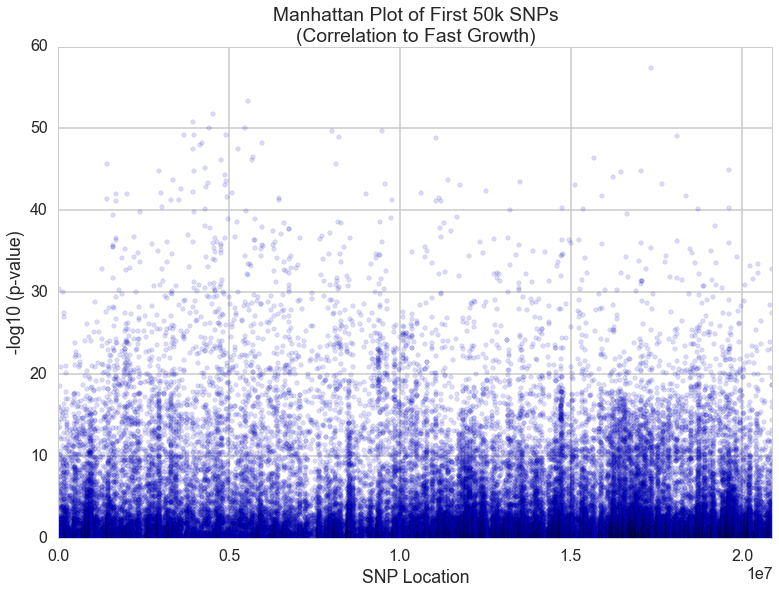

In [575]:
plt.scatter(stats_df.index.values,stats_df['neg_log_p_vals'],alpha=.15)
plt.axis([0,np.max(stats_df.index.values),0,60]);
plt.title('Manhattan Plot of First 50k SNPs\n(Correlation to Fast Growth)');
plt.ylabel('-log10 (p-value)')
plt.xlabel('SNP Location');

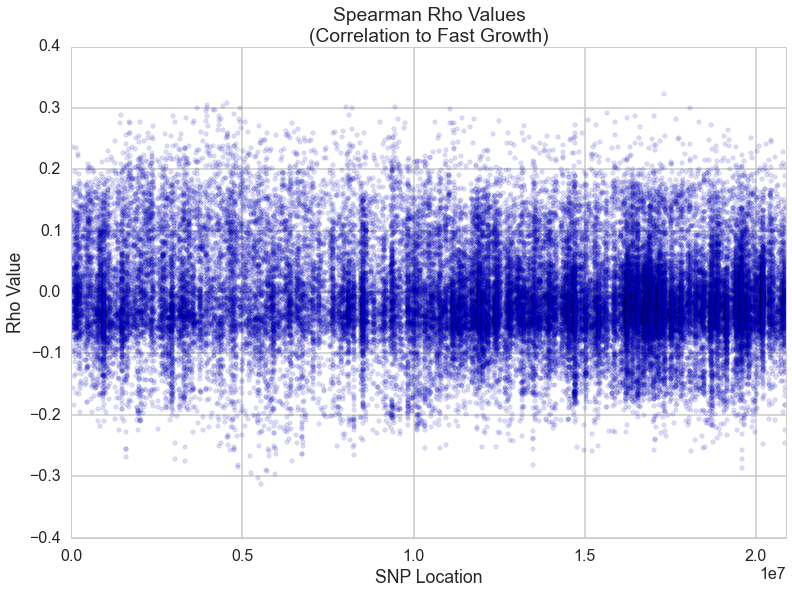

In [576]:
plt.scatter(stats_df.index.values,stats_df['spearman_cor'],alpha=.15);
plt.axis([0,np.max(stats_df.index.values),-.4,.4]);
plt.title('Spearman Rho Values \n(Correlation to Fast Growth)');
plt.ylabel('Rho Value')
plt.xlabel('SNP Location');

## Predicting Days to Maturity with SNP Data

In [ ]:
dfs=['tempdata/SNP_Data/snps1.csv','tempdata/SNP_Data/snps2.csv','tempdata/SNP_Data/snps3.csv',
     'tempdata/SNP_Data/snps4.csv','tempdata/SNP_Data/snps5.csv','tempdata/SNP_Data/snps6.csv',
     'tempdata/SNP_Data/snps7.csv','tempdata/SNP_Data/snps8.csv','tempdata/SNP_Data/snps9.csv',
     'tempdata/SNP_Data/snps10.csv','tempdata/SNP_Data/snps11.csv','tempdata/SNP_Data/snps12.csv',
     'tempdata/SNP_Data/snps13.csv','tempdata/SNP_Data/snps14.csv','tempdata/SNP_Data/snps15.csv',
     'tempdata/SNP_Data/snps16.csv','tempdata/SNP_Data/snps17.csv','tempdata/SNP_Data/snps18.csv',
     'tempdata/SNP_Data/snps19.csv','tempdata/SNP_Data/snps20.csv',]

In [ ]:
def make_useable(dfs,merged_df):
    counter=0
    for df_name in dfs:
        counter+=1
        snpdf=pd.read_csv(df_name, index_col=0)
        
        snpdf=snpdf.transpose()
        
        select  = list(snpdf.index)
        ARRAY=[]
        for name in select:
            if name[:4]=='IRIS':
                und=0
                i=0
                for c in name:
                    if c=='_':
                        und+=1
                    if und==2:
                        upd_name=name[:i]
                        upd_name=upd_name.replace('_', ' ')
                        if upd_name in list(metricsdf.DNA_UNIQUE_ID):
                            ARRAY.append(upd_name)
                        else:
                            ARRAY.append(name)
                        break
                    i+=1
            else:
                ARRAY.append(name)
                
        snpdf['index']=ARRAY
        
        snpdf.set_index('index', inplace=True)
        
        snpdf.index.name = None
        
        snpdf=snpdf.transpose()
        
        snpdf = snpdf.replace(['0/0', '0/1', '1/1', np.nan], [0, 1, 2, 0])
        
        snpdf=snpdf.transpose()
        
        merged_df=pd.merge(left=metricsdf,right=snpdf, left_on='DNA_UNIQUE_ID', right_index=True)
        
        merged_df.set_index('DNA_UNIQUE_ID', inplace=True)
        
        merged_df.drop(['Variety Group (Tree)1', 'source_country', 'rice_blast', 'days_to_mat','stdardized_mat','z_score'], axis=1,inplace=True)
        
        merged_df[['fast']] = merged_df[['fast']].astype(int)
        
        print ('making csv'+str(counter))
        
        merged_df.to_csv('tempdata/finally'+str(counter)+'.csv')

In [ ]:
make_useable(dfs,mat_df)

In [ ]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""

def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    #create gridsearch
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    #fit gridsearch to inputed values
    gs.fit(X, y)
    #determine best estimator and return it
    best = gs.best_estimator_
    return best

from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.4f" % (training_accuracy)
    print "Accuracy on test data:     %0.4f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals 

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats.stats import pearsonr
from sklearn.svm import LinearSVC
import operator
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [ ]:
def do_analysis(df_names):
    counter=0
    for df_name in df_names:
        counter+=1
        
        print ('snps '+str(counter))
        
        merged_df=pd.read_csv(df_name, index_col=0)
        
        lcols=list(merged_df)
        lcols.remove('fast')
        
        itrain, itest = train_test_split(xrange(merged_df.shape[0]), train_size=0.7)
        mask=np.ones(merged_df.shape[0], dtype='int')
        mask[itrain]=1
        mask[itest]=0
        mask = (mask==1)
        mask.shape, mask.sum()
        
        clflog, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, merged_df,lcols, 'fast',1, mask=mask)
        
        clfsvm_final, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, merged_df,lcols, 'fast',1, mask=mask)
        
        reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)
        
        clfsvm=LinearSVC(loss="hinge")
        Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        Xmatrix=merged_df[lcols].values
        Yresp=merged_df['fast'].values

        Xmatrix_train=Xmatrix[mask]
        Xmatrix_test=Xmatrix[~mask]
        Yresp_train=Yresp[mask]
        Yresp_test=Yresp[~mask]

        #set parameters
        parameters = {"C": Cs}
        #create fitmodel with classifier
        fitmodel = GridSearchCV(clfsvm, param_grid=parameters, cv=5, scoring="accuracy")
        #fit model with training data
        fitmodel.fit(Xmatrix_train, Yresp_train)
        #output best values
        print fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_
        
        selectorlinearsvm = SelectKBest(k=25, score_func=pearson_scorer)
        pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])
        
        pipelinearsvm, _,_,_,_  = do_classify(pipelinearsvm, {"svm__C": [0.00001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, merged_df,lcols, 'fast',1, reuse_split=reuse_split)

In [3]:
upd_dfs=['tempdata/finally1.csv','tempdata/finally2.csv','tempdata/finally3.csv',
     'tempdata/finally4.csv','tempdata/finally5.csv','tempdata/finally6.csv',
     'tempdata/finally7.csv','tempdata/finally8.csv','tempdata/finally9.csv',
     'tempdata/finally10.csv','tempdata/finally11.csv','tempdata/finally12.csv',
     'tempdata/finally13.csv','tempdata/finally14.csv','tempdata/finally15.csv',
     'tempdata/finally16.csv','tempdata/finally17.csv','tempdata/finally18.csv',
     'tempdata/finally19.csv','tempdata/finally20.csv',]

In [ ]:
do_analysis(upd_dfs)

    snps 1
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.86
    [[602   0]
     [101   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.90
    [[577  25]
     [ 47  54]]
    ########################################################
    LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.001} 0.799390243902 [mean: 0.79939, std: 0.05104, params: {'C': 0.001}, mean: 0.79817, std: 0.04958, params: {'C': 0.01}, mean: 0.79817, std: 0.04958, params: {'C': 0.1}, mean: 0.79817, std: 0.04958, params: {'C': 1.0}, mean: 0.79817, std: 0.04958, params: {'C': 10.0}, mean: 0.79817, std: 0.04958, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.83
    Accuracy on test data:     0.85
    [[548  54]
     [ 49  52]]
    ########################################################
    
    snps 2
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[595   0]
     [108   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.86
    [[560  35]
     [ 64  44]]
    ########################################################
    LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.01} 0.796341463415 [mean: 0.79573, std: 0.05726, params: {'C': 0.001}, mean: 0.79634, std: 0.05800, params: {'C': 0.01}, mean: 0.79634, std: 0.05800, params: {'C': 0.1}, mean: 0.79634, std: 0.05800, params: {'C': 1.0}, mean: 0.79634, std: 0.05800, params: {'C': 10.0}, mean: 0.79634, std: 0.05800, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[595   0]
     [108   0]]
    ########################################################
    
    snps 3
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.84
    [[592   0]
     [111   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.86
    [[557  35]
     [ 62  49]]
    ########################################################
    LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.001} 0.806097560976 [mean: 0.80610, std: 0.06609, params: {'C': 0.001}, mean: 0.80488, std: 0.06607, params: {'C': 0.01}, mean: 0.80488, std: 0.06607, params: {'C': 0.1}, mean: 0.80488, std: 0.06607, params: {'C': 1.0}, mean: 0.80488, std: 0.06607, params: {'C': 10.0}, mean: 0.80488, std: 0.06607, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.84
    [[592   0]
     [111   0]]
    ########################################################
    
    snps 4
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[597   0]
     [106   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.86
    [[557  40]
     [ 58  48]]
    ########################################################
    LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.01} 0.818292682927 [mean: 0.81585, std: 0.05092, params: {'C': 0.001}, mean: 0.81829, std: 0.05347, params: {'C': 0.01}, mean: 0.81829, std: 0.05347, params: {'C': 0.1}, mean: 0.81829, std: 0.05347, params: {'C': 1.0}, mean: 0.81829, std: 0.05347, params: {'C': 10.0}, mean: 0.81829, std: 0.05347, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[597   0]
     [106   0]]
    ########################################################
    
    snps 5
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.86
    Accuracy on test data:     0.83
    [[585   0]
     [118   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.85
    [[552  33]
     [ 73  45]]
    ########################################################
    LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.001} 0.82256097561 [mean: 0.82256, std: 0.05687, params: {'C': 0.001}, mean: 0.81463, std: 0.05583, params: {'C': 0.01}, mean: 0.81463, std: 0.05583, params: {'C': 0.1}, mean: 0.81463, std: 0.05583, params: {'C': 1.0}, mean: 0.81463, std: 0.05583, params: {'C': 10.0}, mean: 0.81463, std: 0.05583, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.88
    Accuracy on test data:     0.83
    [[566  19]
     [ 98  20]]
    ########################################################
    
    snps 6
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[598   0]
     [105   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.87
    [[573  25]
     [ 68  37]]
    ########################################################
    LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.001} 0.782317073171 [mean: 0.78232, std: 0.06552, params: {'C': 0.001}, mean: 0.78110, std: 0.06824, params: {'C': 0.01}, mean: 0.78110, std: 0.06824, params: {'C': 0.1}, mean: 0.78110, std: 0.06824, params: {'C': 1.0}, mean: 0.78110, std: 0.06824, params: {'C': 10.0}, mean: 0.78110, std: 0.06824, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[598   0]
     [105   0]]
    ########################################################
    
    snps 7
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.84
    [[590   0]
     [113   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.86
    [[559  31]
     [ 65  48]]
    ########################################################
    LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.01} 0.816463414634 [mean: 0.81585, std: 0.04601, params: {'C': 0.001}, mean: 0.81646, std: 0.04828, params: {'C': 0.01}, mean: 0.81646, std: 0.04828, params: {'C': 0.1}, mean: 0.81646, std: 0.04828, params: {'C': 1.0}, mean: 0.81646, std: 0.04828, params: {'C': 10.0}, mean: 0.81646, std: 0.04828, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.84
    [[590   0]
     [113   0]]
    ########################################################
    
    snps 8
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.84
    Accuracy on test data:     0.87
    [[610   0]
     [ 93   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.87
    [[580  30]
     [ 61  32]]
    ########################################################
    LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.001} 0.796341463415 [mean: 0.79634, std: 0.05843, params: {'C': 0.001}, mean: 0.79390, std: 0.05730, params: {'C': 0.01}, mean: 0.79390, std: 0.05730, params: {'C': 0.1}, mean: 0.79390, std: 0.05730, params: {'C': 1.0}, mean: 0.79390, std: 0.05730, params: {'C': 10.0}, mean: 0.79390, std: 0.05730, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.84
    Accuracy on test data:     0.87
    [[610   0]
     [ 93   0]]
    ########################################################
    
    snps 9
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.86
    [[602   0]
     [101   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.89
    [[571  31]
     [ 48  53]]
    ########################################################
    LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.01} 0.795731707317 [mean: 0.79207, std: 0.05024, params: {'C': 0.001}, mean: 0.79573, std: 0.05006, params: {'C': 0.01}, mean: 0.79573, std: 0.05006, params: {'C': 0.1}, mean: 0.79573, std: 0.05006, params: {'C': 1.0}, mean: 0.79573, std: 0.05006, params: {'C': 10.0}, mean: 0.79573, std: 0.05006, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.86
    [[602   0]
     [101   0]]
    ########################################################
    
    snps 10
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[600   0]
     [103   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.88
    [[569  31]
     [ 56  47]]
    ########################################################
    LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.001} 0.790853658537 [mean: 0.79085, std: 0.05225, params: {'C': 0.001}, mean: 0.79024, std: 0.05004, params: {'C': 0.01}, mean: 0.79024, std: 0.05004, params: {'C': 0.1}, mean: 0.79024, std: 0.05004, params: {'C': 1.0}, mean: 0.79024, std: 0.05004, params: {'C': 10.0}, mean: 0.79024, std: 0.05004, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[600   0]
     [103   0]]
    ########################################################
    
    snps 11
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[600   0]
     [103   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.87
    [[572  28]
     [ 61  42]]
    ########################################################
    LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.01} 0.798780487805 [mean: 0.79451, std: 0.06507, params: {'C': 0.001}, mean: 0.79878, std: 0.06653, params: {'C': 0.01}, mean: 0.79878, std: 0.06653, params: {'C': 0.1}, mean: 0.79878, std: 0.06653, params: {'C': 1.0}, mean: 0.79878, std: 0.06653, params: {'C': 10.0}, mean: 0.79878, std: 0.06653, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[600   0]
     [103   0]]
    ########################################################
    
    snps 12
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[600   0]
     [103   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.86
    [[555  45]
     [ 53  50]]
    ########################################################
    LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.01} 0.810365853659 [mean: 0.80976, std: 0.05545, params: {'C': 0.001}, mean: 0.81037, std: 0.05662, params: {'C': 0.01}, mean: 0.81037, std: 0.05662, params: {'C': 0.1}, mean: 0.81037, std: 0.05662, params: {'C': 1.0}, mean: 0.81037, std: 0.05662, params: {'C': 10.0}, mean: 0.81037, std: 0.05662, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[600   0]
     [103   0]]
    ########################################################
    
    snps 13
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[596   0]
     [107   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.87
    [[564  32]
     [ 59  48]]
    ########################################################
    LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.001} 0.808536585366 [mean: 0.80854, std: 0.04830, params: {'C': 0.001}, mean: 0.80793, std: 0.05322, params: {'C': 0.01}, mean: 0.80793, std: 0.05322, params: {'C': 0.1}, mean: 0.80793, std: 0.05322, params: {'C': 1.0}, mean: 0.80793, std: 0.05322, params: {'C': 10.0}, mean: 0.80793, std: 0.05322, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[596   0]
     [107   0]]
    ########################################################
    
    snps 14
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.84
    Accuracy on test data:     0.88
    [[616   0]
     [ 87   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.88
    [[585  31]
     [ 54  33]]
    ########################################################
    LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.001} 0.776219512195 [mean: 0.77622, std: 0.06963, params: {'C': 0.001}, mean: 0.77073, std: 0.06534, params: {'C': 0.01}, mean: 0.77073, std: 0.06534, params: {'C': 0.1}, mean: 0.77073, std: 0.06534, params: {'C': 1.0}, mean: 0.77073, std: 0.06534, params: {'C': 10.0}, mean: 0.77073, std: 0.06534, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.84
    Accuracy on test data:     0.88
    [[616   0]
     [ 87   0]]
    ########################################################
    
    snps 15
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[599   0]
     [104   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.86
    [[559  40]
     [ 60  44]]
    ########################################################
    LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.001} 0.787804878049 [mean: 0.78780, std: 0.06997, params: {'C': 0.001}, mean: 0.78415, std: 0.06799, params: {'C': 0.01}, mean: 0.78415, std: 0.06799, params: {'C': 0.1}, mean: 0.78415, std: 0.06799, params: {'C': 1.0}, mean: 0.78415, std: 0.06799, params: {'C': 10.0}, mean: 0.78415, std: 0.06799, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[599   0]
     [104   0]]
    ########################################################
    
    snps 16
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.84
    [[589   0]
     [114   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.86
    [[556  33]
     [ 67  47]]
    ########################################################
    LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.01} 0.821341463415 [mean: 0.81890, std: 0.04598, params: {'C': 0.001}, mean: 0.82134, std: 0.05008, params: {'C': 0.01}, mean: 0.82134, std: 0.05008, params: {'C': 0.1}, mean: 0.82134, std: 0.05008, params: {'C': 1.0}, mean: 0.82134, std: 0.05008, params: {'C': 10.0}, mean: 0.82134, std: 0.05008, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.84
    [[589   0]
     [114   0]]
    ########################################################
    
    snps 17
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[599   0]
     [104   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.89
    [[577  22]
     [ 58  46]]
    ########################################################
    LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.001} 0.785365853659 [mean: 0.78537, std: 0.07928, params: {'C': 0.001}, mean: 0.78537, std: 0.08049, params: {'C': 0.01}, mean: 0.78537, std: 0.08049, params: {'C': 0.1}, mean: 0.78537, std: 0.08049, params: {'C': 1.0}, mean: 0.78537, std: 0.08049, params: {'C': 10.0}, mean: 0.78537, std: 0.08049, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[599   0]
     [104   0]]
    ########################################################
    
    snps 18
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.84
    Accuracy on test data:     0.87
    [[615   0]
     [ 88   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.89
    [[588  27]
     [ 49  39]]
    ########################################################
    LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.01} 0.765243902439 [mean: 0.76402, std: 0.05819, params: {'C': 0.001}, mean: 0.76524, std: 0.05911, params: {'C': 0.01}, mean: 0.76524, std: 0.05911, params: {'C': 0.1}, mean: 0.76524, std: 0.05911, params: {'C': 1.0}, mean: 0.76524, std: 0.05911, params: {'C': 10.0}, mean: 0.76524, std: 0.05911, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.84
    Accuracy on test data:     0.87
    [[615   0]
     [ 88   0]]
    ########################################################
    
    snps 19
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[595   0]
     [108   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.86
    [[557  38]
     [ 62  46]]
    ########################################################
    LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.01} 0.786585365854 [mean: 0.78476, std: 0.07214, params: {'C': 0.001}, mean: 0.78659, std: 0.07204, params: {'C': 0.01}, mean: 0.78659, std: 0.07204, params: {'C': 0.1}, mean: 0.78659, std: 0.07204, params: {'C': 1.0}, mean: 0.78659, std: 0.07204, params: {'C': 10.0}, mean: 0.78659, std: 0.07204, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.85
    Accuracy on test data:     0.85
    [[595   0]
     [108   0]]
    ########################################################
    
    snps 20
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.84
    Accuracy on test data:     0.87
    [[609   0]
     [ 94   0]]
    ########################################################
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.00
    Accuracy on test data:     0.88
    [[575  34]
     [ 47  47]]
    ########################################################
    LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
         penalty='l2', random_state=None, tol=0.0001, verbose=0) {'C': 0.001} 0.791463414634 [mean: 0.79146, std: 0.05793, params: {'C': 0.001}, mean: 0.79024, std: 0.05853, params: {'C': 0.01}, mean: 0.79024, std: 0.05853, params: {'C': 0.1}, mean: 0.79024, std: 0.05853, params: {'C': 1.0}, mean: 0.79024, std: 0.05853, params: {'C': 10.0}, mean: 0.79024, std: 0.05853, params: {'C': 100.0}]
    using reuse split
    ############# based on standard predict ################
    Accuracy on training data: 0.84
    Accuracy on test data:     0.87
    [[609   0]
     [ 94   0]]
    ########################################################

In [ ]:
def get_coeficcients(df_names):
    counter=0
    coef_dict={}
    for df_name in df_names:
        counter+=1
        
        print ('snps '+str(counter))
        
        merged_df=pd.read_csv(df_name, index_col=0)
        
        lcols=list(merged_df)
        lcols.remove('fast')
        
        itrain, itest = train_test_split(xrange(merged_df.shape[0]), train_size=0.7)
        mask=np.ones(merged_df.shape[0], dtype='int')
        mask[itrain]=1
        mask[itest]=0
        mask = (mask==1)
        mask.shape, mask.sum()
        
        clfsvm_final, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, merged_df,lcols, 'fast',1, mask=mask)
        coefs=dict(zip(merged_df.columns.values[1:],clfsvm_final.coef_[0]))
        coef_dict.update(coefs)
    return coef_dict

In [ ]:
coefs=get_coeficcients(upd_dfs)

    snps 1
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8578
    [[561  39]
     [ 61  42]]
    ########################################################
    snps 2
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8777
    [[577  35]
     [ 51  40]]
    ########################################################
    snps 3
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8791
    [[575  28]
     [ 57  43]]
    ########################################################
    snps 4
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8791
    [[573  43]
     [ 42  45]]
    ########################################################
    snps 5
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8535
    [[556  32]
     [ 71  44]]
    ########################################################
    snps 6
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.9988
    Accuracy on test data:     0.8634
    [[551  30]
     [ 66  56]]
    ########################################################
    snps 7
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8691
    [[563  37]
     [ 55  48]]
    ########################################################
    snps 8
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.9976
    Accuracy on test data:     0.8734
    [[560  27]
     [ 62  54]]
    ########################################################
    snps 9
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.9994
    Accuracy on test data:     0.8848
    [[580  27]
     [ 54  42]]
    ########################################################
    snps 10
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.9976
    Accuracy on test data:     0.8606
    [[560  38]
     [ 60  45]]
    ########################################################
    snps 11
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8791
    [[562  25]
     [ 60  56]]
    ########################################################
    snps 12
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.9994
    Accuracy on test data:     0.8663
    [[550  41]
     [ 53  59]]
    ########################################################
    snps 13
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.9988
    Accuracy on test data:     0.8720
    [[572  32]
     [ 58  41]]
    ########################################################
    snps 14
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8890
    [[575  29]
     [ 49  50]]
    ########################################################
    snps 15
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8578
    [[559  30]
     [ 70  44]]
    ########################################################
    snps 16
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8777
    [[564  29]
     [ 57  53]]
    ########################################################
    snps 17
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8805
    [[563  35]
     [ 49  56]]
    ########################################################
    snps 18
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.9988
    Accuracy on test data:     0.8634
    [[555  43]
     [ 53  52]]
    ########################################################
    snps 19
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 1.0000
    Accuracy on test data:     0.8578
    [[563  22]
     [ 78  40]]
    ########################################################
    snps 20
    using mask
    ############# based on standard predict ################
    Accuracy on training data: 0.9994
    Accuracy on test data:     0.8805
    [[568  25]
     [ 59  51]]
    ########################################################

In [ ]:
coefs_df=pd.DataFrame(coefs, index=['coefficient'])

In [ ]:
coefs_df=coefs_df.transpose()

In [ ]:
new_names = []
for name in coefs_df.index.values:
    i=0
    for c in name:
        i+=1
        if c=='_':
            upd_name=int(name[i:])
            break
    new_names.append(upd_name)

coefs_df.loc[:,'name']=(new_names)
coefs_df.set_index('name',inplace=True)
coefs_df.head()

In [ ]:
stats_df=pd.read_csv('coefs_df.csv', index_col=0)

In [ ]:
plt.scatter(coefs_df.index.values,abs(coefs_df['coefficient']),alpha=.1)
plt.axis([0,np.max(coefs_df.index.values),0,.03]);

In [ ]:
coefs_df.to_csv('coefs_df.csv')

In [ ]:
def combine_snps(dfs):
    counter=0

    for df_name in dfs:
        
        merged_df=pd.read_csv(df_name, index_col=0)
        if counter ==0:
            finaldf=pd.DataFrame(index=list(merged_df.index))
            finaldf=finaldf.transpose()                      
        counter+=1
        merged_df=merged_df.transpose()
        if counter != 1:
            merged_df.drop(['fast'], inplace=True)
        frames=[finaldf,merged_df]
        finaldf=pd.concat(frames)
    finaldf=finaldf.transpose()
    return finaldf

In [ ]:
finaldf=combine_snps(upd_dfs)

In [ ]:
finaldf.to_csv('tempdata/finally_totals.csv')

In [ ]:
snp_cols = list(finaldf.columns[1:])

In [ ]:
corrs = []
for i in snp_cols:
    corr = finaldf.loc[:, [i, 'fast']].corr(method="spearman") 
    corrs.append(corr.iloc[0,1])

In [ ]:
plt.plot(np.abs(corrs), '.', markersize=4, linestyle='None');

In [ ]:
from scipy.stats import spearmanr

snp_cols = list(finaldf.columns[1:])

spearman_cor_dict = {}
p_val_dict = {}
neg_log_p_val_dict = {}
for snp in snp_cols:
    cor,p = spearmanr(list(finaldf['fast']),list(finaldf[snp]))
    spearman_cor_dict.update({snp:(cor)}) 
    p_val_dict.update({snp:(p)})
    pp = -np.log10(p)
    neg_log_p_val_dict.update({snp:(pp)})

In [ ]:
stats_df=pd.DataFrame(spearman_cor_dict, index=['spearman_cor']).append(pd.DataFrame(p_val_dict, index=['p_vals'])).append(pd.DataFrame(neg_log_p_val_dict, index=['neg_log_p_vals']))
stats_df=stats_df.transpose()

new_names = []
for name in stats_df.index.values:
    i=0
    for c in name:
        i+=1
        if c=='_':
            upd_name=int(name[i:])
            break=
    new_names.append(upd_name)

stats_df.loc[:,'name']=(new_names)
stats_df.set_index('name',inplace=True)

In [ ]:
stats_df=pd.read_csv('all_stats_df.csv', index_col=0)

In [ ]:
plt.scatter(stats_df.index.values,stats_df['neg_log_p_vals'],alpha=.15);

In [ ]:
plt.scatter(stats_df.index.values,stats_df['spearman_cor'],alpha=.1);

In [ ]:
plt.scatter(stats_df.index.values,abs(stats_df['spearman_cor']),alpha=.1)
plt.axis([0,np.max(stats_df.index.values),0,.6]);

In [ ]:
stats_df.to_csv('all_stats_df.csv')